<a id='index'></a>
##### Index
* <a href='#introduction'>Introduction</a>
* <a href='#data'>Processed data</a>
    * <a href='#data:load'>Data loading</a>
    * <a href='#data:visualization'>Data visualization</a>
    * <a href='#data:feature'>Feature selection</a>


* <a href='#model'>Model definition and hyperparameter optimization</a>
    * <a href='#model:cat_oc'>One Class classification models</a>
        * <a href='#model_oc:ocsvm'>One Class SVM</a>
        * <a href='#model_oc:AU'>One Class AutoEncoder</a>
        * <a href='#model_oc:...'>...</a>
        
    * <a href='#model:cat_binary'>Binary (supervised) classification models</a>
        * <a href='#model_binary:svm'>SVM</a>
        * <a href='#model_binary:AU'>Autoencoder</a>
        * <a href='#model_binary:...'>...</a>

        
* <a href='#results'>Results</a>
* <a href='#conclusions'>Conclusions</a>


    


<a href='#index'>...</a>
<a id='introduction'></a>
# Introduction

**Imports**

In [136]:
import pandas as pd
import sklearn
import numpy as np
import random
from scipy import stats

# Plot
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
sns.set()

# Configuration
from tqdm.notebook import tqdm
from tqdm import tnrange
import warnings
from ipywidgets import IntProgress
from IPython import display
import time
import os
import json
import copy

# Interactive figures in notebook
# %matplotlib notebook

# Static figures in notebook
%matplotlib inline

# Classification
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from pyod.models import ocsvm, auto_encoder, lof
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

# Evaluation
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer, roc_curve, auc, plot_roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix


**Environment configuration**

In [76]:
def set_display_range(range_columns=pd.options.display.max_columns, range_rows=pd.options.display.max_rows, reset_columns=0, reset_rows=0):
    pd.set_option('display.max_columns', range_columns)
    pd.set_option('display.max_rows', range_rows)
    if (reset_columns): pd.reset_option('display.max_columns')
    if (reset_rows): pd.reset_option('display.max_rows')

set_display_range(range_columns=None, range_rows=10)

<a href='#index'>...</a>
<a id='data'></a>
# Data

<a id='data:load'></a>
## Data loading

![multistarts](media/multistart.png "multistarts")

In [150]:
root_folder_proc = '../OneClass/OneClass_'

# oc_42
df_oc42_X_train = pd.read_csv(root_folder_proc+'42/X_train_42.csv', sep=';')
df_oc42_X_test = pd.read_csv(root_folder_proc+'42/X_test_42.csv', sep=';')
df_oc42_Y_train = pd.read_csv(root_folder_proc+'42/y_train.csv', sep=';')
df_oc42_Y_test = pd.read_csv(root_folder_proc+'42/y_test.csv', sep=';')

# oc_89
df_oc89_X_train = pd.read_csv(root_folder_proc+'89/X_train_89.csv', sep=';')
df_oc89_X_test = pd.read_csv(root_folder_proc+'89/X_test_89.csv', sep=';')
df_oc89_Y_train = pd.read_csv(root_folder_proc+'89/y_train.csv', sep=';')
df_oc89_Y_test = pd.read_csv(root_folder_proc+'89/y_test.csv', sep=';')

# oc_101
df_oc101_X_train = pd.read_csv(root_folder_proc+'101/X_train_101.csv', sep=';')
df_oc101_X_test = pd.read_csv(root_folder_proc+'101/X_test_101.csv', sep=';')
df_oc101_Y_train = pd.read_csv(root_folder_proc+'101/y_train.csv', sep=';')
df_oc101_Y_test = pd.read_csv(root_folder_proc+'101/y_test.csv', sep=';')

# oc_151
df_oc151_X_train = pd.read_csv(root_folder_proc+'151/X_train_151.csv', sep=';')
df_oc151_X_test = pd.read_csv(root_folder_proc+'151/X_test_151.csv', sep=';')
df_oc151_Y_train = pd.read_csv(root_folder_proc+'151/y_train.csv', sep=';')
df_oc151_Y_test = pd.read_csv(root_folder_proc+'151/y_test.csv', sep=';')

# oc_223
df_oc223_X_train = pd.read_csv(root_folder_proc+'223/X_train_223.csv', sep=';')
df_oc223_X_test = pd.read_csv(root_folder_proc+'223/X_test_223.csv', sep=';')
df_oc223_Y_train = pd.read_csv(root_folder_proc+'223/y_train.csv', sep=';')
df_oc223_Y_test = pd.read_csv(root_folder_proc+'223/y_test.csv', sep=';')

In [138]:
target_df = [(df_oc42_Y_train, df_oc42_Y_test), (df_oc89_Y_train, df_oc89_Y_test), (df_oc101_Y_train, df_oc101_Y_test), (df_oc151_Y_train, df_oc151_Y_test), (df_oc223_Y_train, df_oc223_Y_test)]
content_df = [(df_oc42_X_train, df_oc42_X_test), (df_oc89_X_train, df_oc89_X_test), (df_oc101_X_train, df_oc101_X_test), (df_oc151_X_train, df_oc151_X_test), (df_oc223_X_train, df_oc223_X_test)]
ms = [42, 89, 101, 151, 189]

CORE_collection = {}
# CORE_collection structure: dictionary of (float) list
# # CORE_collection[@random_state] = list
# Example: 
# CORE_collection = {42: [1,2,3,4...], 89: [6,9,23,34,...], etc}

X_collection = {}
# X_collection structure: dictionary of (float)-list touple
# X_collection[@random_state] = (X_train_df, Y_train_df)

Y_collection = {}              
# Y_collection structure: dictionary of (float)-list touple
# Y_collection[@random_state] = (Y_train_df, Y_train_df)

for Y, X, RS in zip(target_df, content_df, ms):
    Y[0].loc[Y[0]['ED0DISWHY']==0.0]=-1
    Y[1].loc[Y[1]['ED0DISWHY']==0.0]=-1
    Y[0]['ED0DISWHY'] = Y[0]['ED0DISWHY'].astype("int64")
    Y[1]['ED0DISWHY'] = Y[1]['ED0DISWHY'].astype("int64")
    
    cX = {}
    cY = {}
    
    # Cast core as int
    cX[0] = X[0].astype({"CORE": int})
    cX[1] = X[1].astype({"CORE": int})
    
    # Add core to Y
    Y[0]['CORE'] = cX[0]['CORE']
    Y[1]['CORE'] = cX[1]['CORE']
    
    CORE_collection[RS] = (cX[0]['CORE'],cX[1]['CORE'])
    
    # Set core as index in X
    cX[0] = cX[0].set_index('CORE')
    cX[1] = cX[1].set_index('CORE')
    
    # Set core as index in Y
    cY[0] = Y[0].set_index('CORE')
    cY[1] = Y[1].set_index('CORE')
              
    X_collection[RS] = (cX[0], cX[1])
    Y_collection[RS] = (cY[0], cY[1])
    
X_data = pd.concat([X_collection[42][0], X_collection[42][1]],axis=0)
Y_data = pd.concat([Y_collection[42][0], Y_collection[42][1]],axis=0)


**Alternative: standarize features**

In [151]:
target_df = [(df_oc42_Y_train, df_oc42_Y_test), (df_oc89_Y_train, df_oc89_Y_test), (df_oc101_Y_train, df_oc101_Y_test), (df_oc151_Y_train, df_oc151_Y_test), (df_oc223_Y_train, df_oc223_Y_test)]
content_df = [(df_oc42_X_train, df_oc42_X_test), (df_oc89_X_train, df_oc89_X_test), (df_oc101_X_train, df_oc101_X_test), (df_oc151_X_train, df_oc151_X_test), (df_oc223_X_train, df_oc223_X_test)]
ms = [42, 89, 101, 151, 189]

CORE_collection = {}
# CORE_collection structure: dictionary of (float) list
# # CORE_collection[@random_state] = list
# Example: 
# CORE_collection = {42: [1,2,3,4...], 89: [6,9,23,34,...], etc}

X_collection = {}
# X_collection structure: dictionary of (float)-list touple
# X_collection[@random_state] = (X_train_df, Y_train_df)

Y_collection = {}              
# Y_collection structure: dictionary of (float)-list touple
# Y_collection[@random_state] = (Y_train_df, Y_train_df)

scaler = StandardScaler()

for Y, X, RS in zip(target_df, content_df, ms):
    Y[0].loc[Y[0]['ED0DISWHY']==0.0]=-1
    Y[1].loc[Y[1]['ED0DISWHY']==0.0]=-1
    Y[0]['ED0DISWHY'] = Y[0]['ED0DISWHY'].astype("int64")
    Y[1]['ED0DISWHY'] = Y[1]['ED0DISWHY'].astype("int64")
    
    cX = {}
    cY = {}
    
    # Cast core as int
    cX[0] = X[0].astype({"CORE": int})
    cX[1] = X[1].astype({"CORE": int})
    
    # Add core to Y
    Y[0]['CORE'] = cX[0]['CORE']
    Y[1]['CORE'] = cX[1]['CORE']
    
    CORE_collection[RS] = (cX[0]['CORE'],cX[1]['CORE'])
    
    # Set core as index in X
    cX[0] = cX[0].set_index('CORE')
    cX[1] = cX[1].set_index('CORE')
    
    # Set core as index in Y
    cY[0] = Y[0].set_index('CORE')
    cY[1] = Y[1].set_index('CORE')
    
    # Scale data
    s_data =  scaler.fit_transform(cX[0])
    cX_0 = pd.DataFrame.from_records(s_data)
    cX_0.index = cX[0].index
    cX_0 = cX_0.rename({i:cX[0].columns[i] for i in range(0,44)}, axis='columns')
    
    s_data =  scaler.fit_transform(cX[1])
    cX_1 = pd.DataFrame.from_records(s_data)
    cX_1.index = cX[1].index
    cX_1 = cX_1.rename({i:cX[1].columns[i] for i in range(0,44)}, axis='columns')
              
    X_collection[RS] = (cX_0, cX_1)
    Y_collection[RS] = (cY[0], cY[1])
    
X_data = pd.concat([X_collection[42][0], X_collection[42][1]],axis=0)
Y_data = pd.concat([Y_collection[42][0], Y_collection[42][1]],axis=0)


<a id='data:visualization'></a>
## Data visualization

### Function definition

In [5]:
def column_percentage(df, column, main_label):
    try:
        return len(df.loc[df[column]==main_label])/len(df)
    except:
        return -1

In [6]:
def plot_zero_relevance(df, columns, dim_x, dim_y, main_title='SAMPLE TITLE', titles=None, verbose=0):
    '''
    Prints histogram for every columns desired in a dataframe.
    
    Parameters.
    ------------
    df: Pandas Dataframe
        Data dataframe
        
    columns:  String[]
              Array containning the names of the desired columns
              
    dim_x: int
           Size of the x axis of plot grid. 
    
    dim_y: int
           Size of the y axis of plot grid.
           
    main_title: String
                Title of the figure.
                
    titles: String[]
            Array containing the subtitle of every plot.
    
    verbose: int
             1 to activate verbose mode. Otherwise, hide prints.
                
    '''
    col = 0
    total = df.shape[0]
    if (verbose) : print("Number of 0's:")
    if (titles == None) : titles=columns 
    fig, axes = plt.subplots(dim_x, dim_y, figsize=(16,8))
    fig.suptitle(main_title)
    try:
        for i in range(dim_x):
            for j in range(dim_y):
                if (verbose):
                    print("* "+titles[col]+" \t{} ({:.2f}%)".format(sum(df[columns[col]]==0),sum(df[columns[col]]==0)/total*100))
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    ax = sns.distplot(ax=axes[i,j], x=df[columns[col]], color='#388E3C') # hist=True
                if (ax.lines != []):
                    kde_x, kde_y = ax.lines[0].get_data()
                    ax.fill_between(kde_x, kde_y, where=(kde_x<max(df[columns[col]])*0.1), interpolate=True, color='#EF9A9A')
                axes[i,j].set_title(titles[col])  
                col+=1
    except:
        pass

In [7]:
def zero_relevance(df, columns):
    '''
    Prints 0 value percentage in defined columns.
    
    Parameters.
    ------------
    df: Pandas Dataframe
        Data dataframe
        
    columns:  String[]
              Array containning the names of the desired columns to print  
    '''
    print("Percentage of 0's per column:")
    total = df.shape[0]
    for col in columns:
        print("* "+col+" \t{} ({:.2f}%)".format(sum(df[col]==0),sum(df[col]==0)/total*100))
               

In [8]:
def plot_pair_individual(X, Y, x1, x2):
    '''
    Plots a pair-plot type grid axes for 2 features and one target.
    
    Parameters.
    ------------
    X:  Pandas Dataframe
        X data store.
    
    Y:  Pandas Dataframe
        Y (target) data store.
        
    x1:  String
        Name of the first column
        
    x1:  String
        Name of the second column
    '''
    fig, ax = plt.subplots()
    index = Y.index
    normal_index = index[Y==1]
    anomaly_index = index[Y==-1]
    X_normal = X.loc[normal_index, :]
    X_anomaly = X.loc[anomaly_index, :]
    ax.scatter(X_anomaly[x1], X_anomaly[x2], c='plum', alpha=0.7, label='Anomaly samples')
    ax.scatter(X_normal[x1], X_normal[x2], c='rebeccapurple', alpha=0.7, label='Positive samples')
    plt.xlabel(x1)
    plt.ylabel(x2)
    leg = ax.legend()

In [9]:
def plot_kde(X, Y, col):
    '''    
    Parameters.
    ------------
    X:  Pandas Dataframe
        X data store.
    
    Y:  Pandas Dataframe
        Y (target) data store.
        
    col:  String
        Name of the first column
    '''
    ax = plt.figure(figsize=(6, 4), dpi=80).gca()
    with pd.option_context('mode.chained_assignment',None):
        data = X.copy()
        y_copy = Y.copy()
        data['Class'] = y_copy['ED0DISWHY']
        data['Class'].loc[data['Class']==1] = 'Deceased'
        data['Class'].loc[data['Class']==-1] = 'Not deceased'

        sns.histplot(data=data, x=col, hue="Class", palette=sns.color_palette("CMRmap_r", n_colors=2), kde=True)

    plt.title(f'Feture {col}')
    ax.text(185, 20,'Text Here', fontsize=9) #add text
    plt.show()


In [16]:
def plot_joint(X, Y, columns, kind='scatter'):
    '''
    kind = { “scatter” | “kde” | “hist”}
    '''
    data = X.copy()
    data['Class'] = 0
    with pd.option_context('mode.chained_assignment',None):
        data['Class'].loc[Y['ED0DISWHY']==1] = 'Deceased'
        data['Class'].loc[Y['ED0DISWHY']==-1] = 'Not deceased'
        j = sns.jointplot(data=data, x=columns[0], y=columns[1], palette=sns.color_palette("CMRmap_r", n_colors=2),hue="Class", kind=kind)
    #     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.show()

In [11]:
def plot_box_plot(X, Y, features, save=0):
    '''
    Plots plot-box type grid axes for 1 feature and one target.
    
    Parameters.
    ------------
    X:  Pandas Dataframe
        X data store.
    
    Y:  Pandas Dataframe
        Y (target) data store.
        
    features: String[]
              Array containning the names of the desired columns to print
  
    save: int
            1 value, save plots. Otherwise, print plots.
    '''
    path = './boxplots'
    if (not os.path.isdir(path)):
        try:
            os.mkdir(path)
        except OSError:
            print ("Creation of the directory %s failed" % path)
        else:
            print ("Successfully created the directory %s " % path)
    for feat in features:
        boxp = sns.boxplot(y=X[feat],x=Y['ED0DISWHY'])
        if (save):
            fig = boxp.get_figure()
            fig.savefig(path+'/bp_'+feat+'.png')
            plt.close()
        else:
            plt.show()

# plot_box_plot(X=X_collection[42][0], Y=Y_collection[42][0], features=X_collection[42][0].columns, save=1

### Visualization

**Pairwise representation of features, visualizing the relationship with the target class.**

Individual pairs.

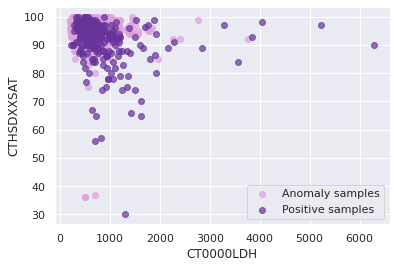

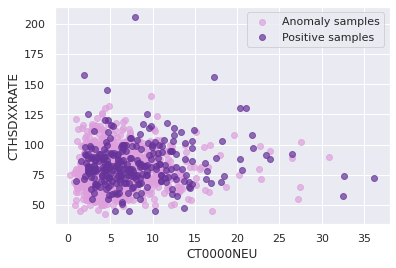

In [11]:
plot_pair_individual(X_data, Y_data['ED0DISWHY'], 'CT0000LDH', 'CTHSDXXSAT')
plot_pair_individual(X_data, Y_data['ED0DISWHY'], 'CT0000NEU', 'CTHSDXXRATE')

Record features taken during admission and registered information about diagnosis and procedements (according to CIE10 codification).

Text(0.5, 1.08, "Positive/anomaly samples' features taken during admision and diagnosis/procedements values (according to CIE10 codification)")

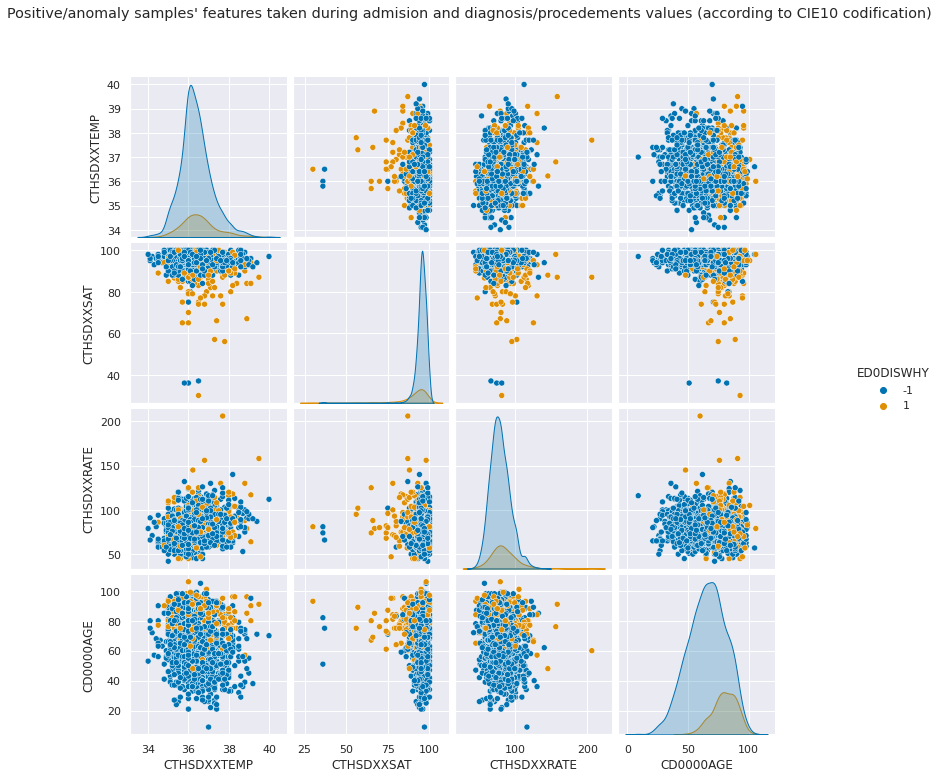

In [12]:
pp = sns.pairplot(pd.concat([X_data[['CTHSDXXTEMP', 'CTHSDXXSAT', 'CTHSDXXRATE', 'CD0000AGE']], Y_data],axis=1), hue='ED0DISWHY', palette='colorblind')
pp.fig.suptitle("Positive/anomaly samples' features taken during admision and diagnosis/procedements values (according to CIE10 codification)", y=1.08)

Distribution representation of features for positive and anomaly samples.


Distribution of features per class:

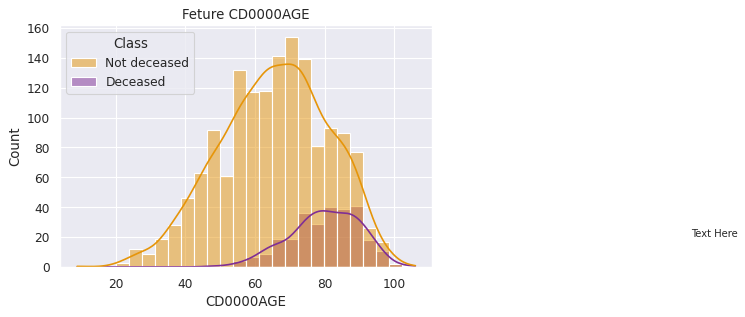

In [167]:
plot_kde(X_data, Y_data, 'CD0000AGE')

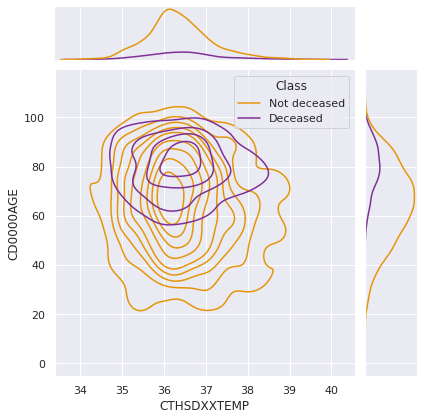

In [168]:
# ['CTHSDXXTEMP', 'CTHSDXXSAT', 'CTHSDXXRATE', 'CD0000AGE']
plot_joint(X_collection[42][0], Y_collection[42][0], ['CTHSDXXTEMP', 'CD0000AGE'], kind = 'kde')

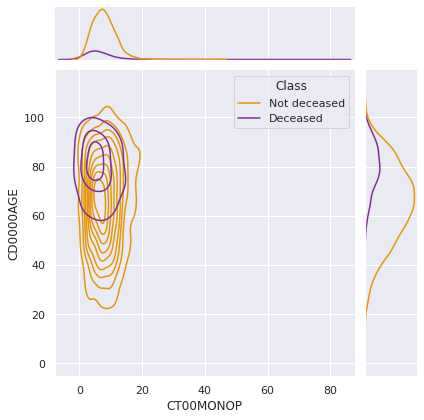

In [169]:
# ['CTHSDXXTEMP', 'CTHSDXXSAT', 'CTHSDXXRATE', 'CD0000AGE']
plot_joint(X_collection[42][0], Y_collection[42][0], ['CT00MONOP', 'CD0000AGE'], kind = 'kde')

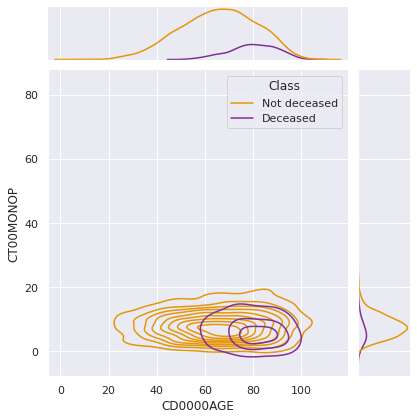

In [171]:
# ['CTHSDXXTEMP', 'CTHSDXXSAT', 'CTHSDXXRATE', 'CD0000AGE']
plot_joint(X_collection[42][0], Y_collection[42][0], ['CD0000AGE', 'CT00MONOP'], kind = 'kde')

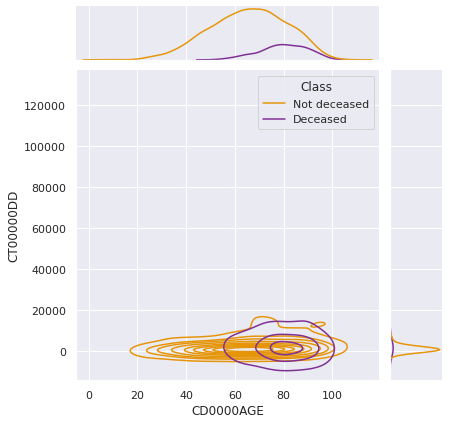

In [17]:
# ['CTHSDXXTEMP', 'CTHSDXXSAT', 'CTHSDXXRATE', 'CD0000AGE']
plot_joint(X_collection[42][0], Y_collection[42][0], ['CD0000AGE', 'CT00000DD'], kind = 'kde')

# Methods


<a id='data:feature'></a>
## Feature selection

### Ranking features based on variance (most to least)

In [ ]:
## Feature selection / filtering based on ranking features based on variance (from most [top1] to least [top last] variance)

columns = X_collection[42][0].columns.to_numpy()

## Keep columns that are not desired to remov
keep = ['CD000MSEX', 'CD000FSEX', 'CD0000AGE', 'CTHSDXXSAT']
columns = np.setdiff1d(columns, keep)

total_columns = len(X_collection[42][0].columns) - len(keep)
columns_to_drop = 10

print(f'Number of columns to drop: {columns_to_drop}\n')
print(f'Original feature size: {X_collection[42][0].shape[1]}. New feature size: {X_collection[42][0].shape[1]-columns_to_drop}.\n')

variance = {k: None for k in columns}
for universe in ms:
    remove = []
    print(f'Universe {universe} top variance:')
    for col in columns:
        var = X_collection[universe][0][col].var()
        variance[col] = var
    
    variance = {k: v for k, v in sorted(variance.items(), key=lambda item: item[1], reverse=True)}
#   print(f'Universe {universe} top variance:')
    for i, col in zip(range(len(variance)), variance): 
        print(f"{i+1}. {col}: {variance[col]:.3f}")
        
    variance_keys = list(variance.keys())
    
    X_collection[universe][0].drop(columns=variance_keys[total_columns-columns_to_drop:], axis=1, inplace=True)
    X_collection[universe][1].drop(columns=variance_keys[total_columns-columns_to_drop:], axis=1, inplace=True) 
    
    print(f'Removed features in universe {universe}:')
    print(f'{variance_keys[-total_columns-columns_to_drop:]}\n')

### Ranking features based on MAD (most to least)

In [ ]:
## Feature selection / filtering based on ranking features based on MAD (from most [top1] to least [top last] variance)

columns = X_collection[42][0].columns.to_numpy()

## Keep columns that are not desired to remove
keep = ['CD000MSEX', 'CD000FSEX', 'CD0000AGE', 'CTHSDXXSAT']
columns = np.setdiff1d(columns, keep)

total_columns = len(X_collection[42][0].columns) - len(keep)
columns_to_drop = 30

print(f'Number of columns to drop: {columns_to_drop}\n')
print(f'Original feature size: {X_collection[42][0].shape[1]}. New feature size: {X_collection[42][0].shape[1]-columns_to_drop}.\n')

mad_list = {k: None for k in columns}
for universe in ms:
    remove = []
    print(f'Universe {universe} top variance:')
    for col in columns:
        mad = stats.median_abs_deviation(X_collection[universe][0][col])
        mad_list[col] = mad
    
    mad_list = {k: v for k, v in sorted(mad_list.items(), key=lambda item: item[1], reverse=True)}
#   print(f'Universe {universe} top variance:')
    for i, col in zip(range(len(mad_list)), mad_list): 
        print(f"{i+1}. {col}: {mad_list[col]:.3f}")
        
    mad_keys = list(mad_list.keys())
    
    X_collection[universe][0].drop(columns=mad_keys[total_columns-columns_to_drop:], axis=1, inplace=True)
    X_collection[universe][1].drop(columns=mad_keys[total_columns-columns_to_drop:], axis=1, inplace=True) 
    
    print(f'Removed features in universe {universe}:')
    print(f'{mad_keys[total_columns-columns_to_drop:]}\n')

### Ranking features based on variance RATIO (most to least)

In [7]:
## Feature selection / filtering based on (variance_total % variance_positive) ratio 

columns = X_collection[42][0].columns.to_numpy()

## Keep columns that are not desired to remove
keep = ['CD000MSEX', 'CD000FSEX', 'CD0000AGE', 'CTHSDXXSAT']
columns = np.setdiff1d(columns, keep)

total_columns = len(X_collection[42][0].columns) - len(keep)
columns_to_drop = 33

print(f'Number of columns to drop: {columns_to_drop}\n')
print(f'Original feature size: {X_collection[42][0].shape[1]}. New feature size: {X_collection[42][0].shape[1]-columns_to_drop}.\n')

ratio = {k: None for k in columns}
for universe in ms:
    remove = []
    positive_index = Y_collection[universe][0].loc[Y_collection[universe][0]['ED0DISWHY']==1].index

    for col in columns: 
        # Variance with normal and abnormal samples
        var = X_collection[universe][0][col].var()
        # Variance with normal samples
        var_pos = X_collection[universe][0].loc[positive_index, :][col].var()
        ratio_value = var/var_pos
        ratio[col] = ratio_value
    
    ratio = {k: v for k, v in sorted(ratio.items(), key=lambda item: item[1])}
#     print(f'Universe {universe} top variance:')
#     for i, col in zip(range(len(ratio)), ratio): 
#         print(f"{i+1}. {col}: {ratio[col]:.3f}")
    ratio_keys = list(ratio.keys())

    X_collection[universe][0].drop(columns=ratio_keys[total_columns-columns_to_drop:], axis=1, inplace=True)
    X_collection[universe][1].drop(columns=ratio_keys[total_columns-columns_to_drop:], axis=1, inplace=True) 
    
    print(f'Removed features in universe {universe}:')
    print(f'{ratio_keys[total_columns-columns_to_drop:]}\n')

Number of columns to drop: 33

Original feature size: 44. New feature size: 11.

Removed features in universe 42:
['CT000LEUC', 'CT00000NA', 'CT000000U', 'CT00000DD', 'CT0000INR', 'CT00MONOP', 'CT000APTT', 'CT0000NEU', 'CT0000GLU', 'CTHSDXXRATE', 'CT0000PCR', 'CT0000COM', 'CT000000K', 'CT00000AP', 'CT0000VCM', 'CT000HCTO', 'CT0000ADW', 'CT0000HGB', 'CT0000HEM', 'CT0000VPM', 'CTHSDXXTEMP', 'CT000PLAQ', 'CT000CHCM', 'CT0000BAS', 'CT0000HCM', 'CT0000LIN', 'CT000NEUP', 'CT000LINP', 'CT0000GGT', 'CT0000SYM', 'CT000BASP', 'CT000EOSP', 'CT0000EOS']

Removed features in universe 89:
['CT0000LIN', 'CT000000U', 'CT00000TP', 'CT00000NA', 'CT00000DD', 'CT00MONOP', 'CT0000NEU', 'CT0000INR', 'CT0000GLU', 'CT000APTT', 'CTHSDXXRATE', 'CT0000PCR', 'CT000000K', 'CT00000AP', 'CT0000COM', 'CT0000VCM', 'CT0000ADW', 'CT000HCTO', 'CTHSDXXTEMP', 'CT0000HGB', 'CT0000HEM', 'CT000PLAQ', 'CT0000VPM', 'CT000CHCM', 'CT0000HCM', 'CT0000BAS', 'CT000NEUP', 'CT000LINP', 'CT0000GGT', 'CT000BASP', 'CT0000SYM', 'CT000EOSP

### Ranking features based on MAD RATIO (most to least)

In [ ]:
## Feature selection / filtering based on (variance_total % variance_positive) ratio 

columns = X_collection[42][0].columns.to_numpy()


## Keep columns that are not desired to remove
keep = ['CD000MSEX', 'CD000FSEX', 'CD0000AGE', 'CTHSDXXSAT']
columns = np.setdiff1d(columns, keep)

total_columns = len(X_collection[42][0].columns) - len(keep)
columns_to_drop = 30

print(f'Number of columns to drop: {columns_to_drop}\n')
print(f'Original feature size: {X_collection[42][0].shape[1]}. New feature size: {X_collection[42][0].shape[1]-columns_to_drop}.\n')

ratio = {k: None for k in columns}
for universe in ms:
    remove = []
    positive_index = Y_collection[universe][0].loc[Y_collection[universe][0]['ED0DISWHY']==1].index

    for col in columns: 
        # Variance with normal and abnormal samples
        mad = stats.median_abs_deviation(X_collection[universe][0][col])
        # Variance with normal samples
        mad_pos = stats.median_abs_deviation(X_collection[universe][0].loc[positive_index, :][col])

        # Avoid divide by 0
        ratio_value = mad/mad_pos if mad_pos>0 else mad/0.00001
        ratio[col] = ratio_value
    
    ratio = {k: v for k, v in sorted(ratio.items(), key=lambda item: item[1])}
    
#     Print TOP features per universe
#     print(f'Universe {universe} top MAD:')
#     for i, col in zip(range(len(ratio)), ratio): 
#         print(f"{i+1}. {col}: {ratio[col]:.7f}")
    ratio_keys = list(ratio.keys())

    X_collection[universe][0].drop(columns=ratio_keys[1*(total_columns-columns_to_drop):], axis=1, inplace=True)
    X_collection[universe][1].drop(columns=ratio_keys[1*(total_columns-columns_to_drop):], axis=1, inplace=True) 
    
    print(f'Removed features in universe {universe}:')
    print(f'{ratio_keys[total_columns-columns_to_drop:]}\n')

<a href='#index'>...</a>
<a id='model'></a>
## Model definition and hyperparameter optimization

### Function definition

#### ToolsVisualization

In [243]:
class ToolsVisualization:
    def __init__(self):
        self._tool = ToolsClassification()
    
    def outlierness_supervised(self, y_true, outlier_score, normal=1, anomaly=-1, threshold=-1): 
        # Visualize outlier-score (SUPERVISED WAY)
        for i in outlier_score:
            ax = plt.figure(figsize=(14, 4), dpi=80).gca()
            plt.title(f'Outlierness of Universe {i}')
            plt.xlabel('Outlierness')

            positive_index = y_true[i][1].loc[y_true[i][1]['ED0DISWHY']==normal].index
            anomaly_index = y_true[i][1].loc[y_true[i][1]['ED0DISWHY']==anomaly].index

            sns.stripplot(x=outlier_score[i][anomaly_index], alpha = .4, edgecolor = 'none', color = 'darkblue', label='Anomaly', ax = ax)
            plt.axvline(x=outlier_score[i][anomaly_index].median(), ymin=0.25, ymax=0.75, color = 'darkblue', linestyle='-', alpha=0.7)
            sns.stripplot(x=outlier_score[i][positive_index], alpha = .8, edgecolor = 'black', color='red', label='Positive', ax = ax)
            plt.axvline(x=outlier_score[i][positive_index].median(), ymin=0.25, ymax=0.75, color='red', linestyle='-', alpha=0.7)

            if (threshold != -1):  plt.axvline(x=threshold, color='g', linestyle='-')
            plt.legend()
            plt.show()
        #     plt.xticks(np.arange(min(outlierness_dict[universe]), max(outlierness_dict[universe])+1, 1.0))
        
    
    def outlierness_unsupervised(self, outlier_score, normal=1, anomaly=-1, quantile = -1, title = 'Outlierness of Universe '): 
    # Visualize outlier-score (UNSUPERVISED WAY)
        for i in outlier_score:
            ax = plt.figure(figsize=(14, 4), dpi=80).gca()
            plt.title(f'{title}{i}')
            plt.xlabel('Outlierness')
            if (quantile != -1):  
                q = outlier_score[i].quantile(quantile)
                low_q = outlier_score[i].loc[outlier_score[i]<q]
                high_q = outlier_score[i].loc[outlier_score[i]>=q]
                sns.stripplot(x=low_q, ax = ax, color='blue', label = f'Lower than quantile {quantile}')
                sns.stripplot(x=high_q, ax = ax, color='orange', label = f'Higher than quantile {quantile}')
                plt.axvline(x=q, color='g', linestyle='-', label=f'Quantile {quantile}: ~{q:.6}')
                plt.legend()
            else:
                sns.stripplot(x=outlier_score[i], ax = ax)

    #         plt.xticks(np.arange(min(outlier_score[universe]), max(outlier_score[universe])+1, 1.0))
    
    def confusion_matrix_plot(self, y_true, y_pred, labels, normal, anomaly, rs='UNDEFINED'):

        array = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)

        df_cm = pd.DataFrame({normal: array[:,0], anomaly: array[:,1]}, index=[normal, anomaly])

        total = df_cm[normal].sum()+df_cm[anomaly].sum()

        df_cm_p = df_cm.applymap(str)
        df_cm_p[normal][normal] = df_cm_p[normal][normal]+'\n'+"{:.2f}".format(df_cm[normal][normal]/total*100)+'%'
        df_cm_p[normal][anomaly] = df_cm_p[normal][anomaly]+'\n'+"{:.2f}".format(df_cm[normal][anomaly]/total*100)+'%'
        df_cm_p[anomaly][normal] = df_cm_p[anomaly][normal]+'\n'+"{:.2f}".format(df_cm[anomaly][normal]/total*100)+'%'
        df_cm_p[anomaly][anomaly] = df_cm_p[anomaly][anomaly]+'\n'+"{:.2f}".format(df_cm[anomaly][anomaly]/total*100)+'%'

        plt.figure(figsize=(8,5))
        plt.title('Confusion matrix of universe {}'.format(rs))
        sns.heatmap(df_cm, annot=df_cm_p, fmt='', annot_kws={"size": 15}) # font size
        plt.ylabel("Ground truth")
        plt.xlabel("Predicted") 

        plt.show()
    
    def confusion_matrix_plot_total(self, y_true, y_pred, labels, normal, anomaly):
    
        fig, axs = plt.subplots(3,2, figsize=(20, 20))
        axs_flat = axs.flat[:-1]
        axs[-1, -1].axis('off')
        for i, ax in enumerate(axs_flat):
            universe = [*y_true][i]

            array = confusion_matrix(y_true=y_true[universe][1], y_pred=y_pred[universe], labels=labels)

            df_cm = pd.DataFrame({normal: array[:,0], anomaly: array[:,1]}, index=[normal, anomaly])

            total = df_cm[normal].sum()+df_cm[anomaly].sum()

            df_cm_p = df_cm.applymap(str)
            df_cm_p[normal][normal] = df_cm_p[normal][normal]+'\n'+"{:.2f}".format(df_cm[normal][normal]/total*100)+'%'
            df_cm_p[normal][anomaly] = df_cm_p[normal][anomaly]+'\n'+"{:.2f}".format(df_cm[normal][anomaly]/total*100)+'%'
            df_cm_p[anomaly][normal] = df_cm_p[anomaly][normal]+'\n'+"{:.2f}".format(df_cm[anomaly][normal]/total*100)+'%'
            df_cm_p[anomaly][anomaly] = df_cm_p[anomaly][anomaly]+'\n'+"{:.2f}".format(df_cm[anomaly][anomaly]/total*100)+'%'

            sns.heatmap(df_cm, annot=df_cm_p,ax=ax, fmt='', annot_kws={"size": 15}) # font size
            ax.set_ylabel('Ground truth')
            ax.set_xlabel('Predicted')
            ax.set_title('Confusion matrix of universe {}'.format(universe))
 
    def ROC_plot_total(self, y_true, outlier_score, normal):
    
        fig, axs = plt.subplots(3,2, figsize=(20, 20))
        axs_flat = axs.flat[:-1]
        axs[-1, -1].axis('off')
        for i, ax in enumerate(axs_flat):
            universe = [*y_true][i]
            norm_outlier_score = self._tool.normalize(outlier_score[universe])
            fpr, tpr, thresholds = roc_curve(y_true[universe][1], norm_outlier_score, pos_label=normal)
            roc_auc = auc(fpr, tpr)

            ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
            ax.legend(loc = 'lower right')
            ax.plot([0, 1], [0, 1],'r--')
            ax.set_xlim([0, 1])
            ax.set_ylim([0, 1])
            ax.set_ylabel('True Positive Rate')
            ax.set_xlabel('False Positive Rate')
            ax.set_title('Receiver Operating Characteristic {}'.format(universe))
 
    def precision_recall_plot_total(self, y_true, outlier_score, normal):
        fig, axs = plt.subplots(3,2, figsize=(20, 20))
        axs_flat = axs.flat[:-1]
        axs[-1, -1].axis('off')
        for i, ax in enumerate(axs_flat):
            universe = [*y_true][i]
            norm_outlier_score = self._tool.normalize(outlier_score[universe])
            precision, recall, thresholds = precision_recall_curve(y_true[universe][1], norm_outlier_score, pos_label=normal)
            p_r_auc = auc(recall, precision)
       
            ax.plot(precision, recall, 'b', label = 'AUC = %0.2f' % p_r_auc)
            ax.legend(loc = 'lower right')
            ax.set_xlim([0, 1])
            ax.set_ylim([0, 1])
            ax.set_ylabel('Precision')
            ax.set_xlabel('Recall')
            ax.set_title('Precision-Recall curve {}'.format(universe))
    
    def outlierness_plot_total(self, y_true, y_pred, outlier_score, normal, anomaly, xlim0=-1, xlim1=-1): 
    # Visualization of the outlierness distribution
        fig, axs = plt.subplots(4,1, figsize=(11, 20))
        axs_flat = axs.flat

        for i, ax in enumerate(axs_flat):
            universe = [*y_true][i]

            gt_positive_index = y_true[universe][1].loc[y_true[universe][1]['ED0DISWHY']==normal].index
            gt_negative_index = y_true[universe][1].loc[y_true[universe][1]['ED0DISWHY']==anomaly].index

            y_pred_indexed = pd.Series(y_pred[universe], index=y_true[universe][1].index) 
            
            p_positive_index = y_pred_indexed.loc[y_pred_indexed==normal].index
            p_negative_index = y_pred_indexed.loc[y_pred_indexed==anomaly].index

#             mask_true_positive_index = np.in1d(gt_positive_index, p_positive_index)
#             true_positive_index = gt_positive_index[mask_true_positive_index]
#             mask_false_negative_index = np.in1d(gt_positive_index, p_negative_index)
#             false_negative_index = gt_positive_index[mask_false_negative_index]

#             mask_true_negative_index = np.in1d(gt_negative_index, p_negative_index)
#             true_negative_index = gt_negative_index[mask_true_negative_index]
#             mask_false_positive_index = np.in1d(gt_negative_index, p_positive_index)
#             false_positive_index = gt_negative_index[mask_false_positive_index]

            true_positive_index = gt_positive_index.intersection(p_positive_index)
            false_negative_index = gt_positive_index.intersection(p_negative_index)

            true_negative_index = gt_negative_index.intersection(p_negative_index)
            false_positive_index = gt_negative_index.intersection(p_positive_index)
                        
            d = {'Outlier-score':outlier_score[universe].loc[true_positive_index], 'Classification':len(outlier_score[universe].loc[true_positive_index])*['True Positive']}
            df_true_positive = pd.DataFrame(data=d)
            d = {'Outlier-score':outlier_score[universe].loc[false_positive_index], 'Classification':len(outlier_score[universe].loc[false_positive_index])*['False Positive']}
            df_false_positive = pd.DataFrame(data=d)
            d = {'Outlier-score':outlier_score[universe].loc[true_negative_index], 'Classification':len(outlier_score[universe].loc[true_negative_index])*['True Negative']}
            df_true_negative = pd.DataFrame(data=d)
            d = {'Outlier-score':outlier_score[universe].loc[false_negative_index], 'Classification':len(outlier_score[universe].loc[false_negative_index])*['False Negative']}
            df_false_negative = pd.DataFrame(data=d)

            df_scores = pd.concat([df_true_positive, df_false_positive, df_true_negative, df_false_negative])

            plt.title('Outlierness distribution')
            if (xlim0!=-1 and xlim1!=-1):
                plt.xlim([xlim0, xlim1])
            sns.boxplot(y='Classification', x='Outlier-score', data=df_scores, whis=np.inf, ax=ax)
            sns.stripplot(y='Classification', x='Outlier-score', data=df_scores, color=".25", ax=ax)


#### ToolsClassification

In [122]:
class ToolsClassification:
    def __init__(self):
        pass
    
    def metric_evaluation(self, y_true, y_pred, outlier_score, pos_label):
        cm = {}
        evaluations = pd.DataFrame(columns=['AUC', 'Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1-score'])
        for universe in y_true:
            # Confusion matrix calculation
            array = confusion_matrix(y_true=y_true[universe][1], y_pred=y_pred[universe], labels=[pos_label,-pos_label])
            cm[universe]=(' {} {}\n{} {}'.format(array[0,0], array[0,1], array[1,0], array[1,1]))

            # Metric calculation
            # AUC, Accuracy, Precision, Sensitivity, Specifity, F1-score
            norm_outlier_score = self.normalize(outlier_score[universe])
            fpr, tpr, thresholds = roc_curve(y_true[universe][1], norm_outlier_score, pos_label=pos_label)
            roc_auc = auc(fpr, tpr)
            met = [roc_auc,\
                   accuracy_score(y_true = y_true[universe][1],y_pred = y_pred[universe]),\
                   precision_score(y_true = y_true[universe][1],y_pred = y_pred[universe]),\
                   recall_score(y_true = y_true[universe][1],y_pred = y_pred[universe], pos_label=pos_label),\
                   recall_score(y_true = y_true[universe][1],y_pred = y_pred[universe], pos_label=-pos_label),\
                   f1_score(y_true = y_true[universe][1],y_pred = y_pred[universe], pos_label=pos_label)]

            evaluations.loc[universe] = met

        pt = PrettyTable()
        pt.field_names = ["Prediction"]+['Pos Neg [{}]'.format(x) for x in ms]
        pt.add_row(['Positive\nNegative']+list(cm.values()))
        pt.add_row(6*['---------------'])
        for metric in evaluations.columns:
            formated_ev = ["{:.3f}".format(x) for x in evaluations[metric]]
            max_i = np.argmax(evaluations[metric])
            formated_ev[max_i] = formated_ev[max_i]+'*'
            pt.add_row([metric]+formated_ev)

        pt.align['Prediction']='l'
        print(pt)

        return evaluations
    
    def normalize(self, arr):
        return (arr-min(arr))/(max(arr)-min(arr))
    
    def custom_auc(self, ground_truth, predictions):
        # I need only one column of predictions["0" and "1"]. You can get an error here
        # while trying to return both columns at once
        prob = self.normalize(predictions)
        fpr, tpr, _ = roc_curve(ground_truth, prob, pos_label=1)    
        return auc(fpr, tpr)
        
    def oc_split(self, Y, train, test, normal):
        indexed_train = zip(np.arange(0,train.shape[0],1), train)
        # Index to remove from train set
        del_index = []

        for train_index, df_index in indexed_train: 
            sample = Y.iloc[df_index]
            if (sample['ED0DISWHY']!=normal):
                # Append anomaly samples from train to test
                test = np.append(test, df_index)
                # Update train (anomaly) indexes
                del_index.append(train_index)
        # Remove anomaly samples from train
        train = np.delete(train, del_index, 0)
        return train, test
    
    def nested_cv(self, X, Y, outer_folds, inner_folds, model, parameters, score, normal_target):

        outer_loop=1
        max_score = -1
        score_outer = []
        inner_results = []

        # Define outer-loop
        skfold_outer = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=1)
        for train_outer, test_outer in skfold_outer.split(X, Y):
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')

                print("Outer loop folds: {}/{}".format(outer_loop, outer_folds))

                # Outer-loop data retrieve
                X_train_outer, X_test_outer = X.iloc[train_outer], X.iloc[test_outer]
                Y_train_outer, Y_test_outer = Y.iloc[train_outer], Y.iloc[test_outer]

                # Define inner loop
                skfold_inner = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=1)

                # Transfering anomaly samples from train to test subsets.

                skfold_inner_cv = list()
                for train_inner, test_inner in skfold_inner.split(X_train_outer, Y_train_outer):
                    # List containing indexes with train subset clear of anomaly samples
                    skfold_inner_cv.append((self.oc_split(Y, train_inner, test_inner, normal_target)))

                # GRIDSEARCH
                # Obtain best model                
                scorer = make_scorer(score, pos_label=normal_target)

                if ('LOF' in str(model)):
                    scorer = make_scorer(self.custom_auc, greater_is_better=True, needs_proba=True)

                gsearch = GridSearchCV(model, param_grid=parameters, cv=skfold_inner_cv, scoring=scorer)
                gsearch.fit(X.iloc[train_outer], Y.iloc[train_outer])
                inner_results.append(gsearch.cv_results_)

                # Best estimator
                estimator = gsearch.best_estimator_

                if ('LOF'in str(model)):
                    dec_y = estimator.decision_function(X_test_outer)
                    fpr, tpr, thresholds = roc_curve(Y.iloc[test_outer], self.normalize(dec_y), pos_label=normal_target)
                    score_val = auc(fpr, tpr)
    #                  = score(y_true=Y.iloc[test_outer],y_pred= pred_y, pos_label=normal_target)
                else:
                    pred_y = estimator.predict(X_test_outer)
                    score_val = score(y_true=Y.iloc[test_outer],y_pred= pred_y, pos_label=normal_target)

                score_outer.append(score_val)
                if (score_val>=max(score_outer)): best_estimator = estimator

                outer_loop+=1

        print("Metrics: f1-score")
        print("Summary:")
        for i in range(outer_folds):
            best_ifold = np.where(inner_results[i]['rank_test_score'] == 1)[0][0]
            print("Outer fold nº{}.".format(i+1))
            print("Parameters (best of cv): {}".format(inner_results[i]['params'][best_ifold]))
            print("Score (best of cv): {:.3}±{:.2}".format(inner_results[i]['mean_test_score'][best_ifold], inner_results[i]['std_test_score'][best_ifold]))
            print("Score (outer): {:.4}\n".format(score_outer[i]))
        return best_estimator
        

<a id='model:cat_oc'></a>
### One Class classification models

TODO: EXPLANATION

<a id='model_oc:ocsvm'></a>
### Boundary based methods
Boundary methods aims to set a decision boundary around a selected group of samples, represented as points. This decision boundary usually really on distances in order to be correctly set up, and as these are defined in an OCC scenario, the decision boundary is built up around the samples belonging to the target (positive) class. They ensure the accept of positive samples while minimizing the number of accepted outliers as positive.

#### One-Class SVM (OCSVM)
Original paper.

[source](https://www.is.mpg.de/publications/815)

One-Class SVM is a derivation form the classical Vapnik's SVM work made for the progress of statistical learning theory(Vapnik, 1995). The basic idea of the SVM resides on mapping the input data into a high-dimensional feature space, and then, build an hyperplane around the training data that will maximize the distance between patterns, where the hyperplane in that high-dimensional space will serve as segregation method for the new unseen test samples. SVMs try to minimize the generalization error by the addition of a regularization parameters. Later in this section will be discussed deeply the idea of this regularization parameter but applied to the OCSVM case.

This same concepts apply to the OCC version of the algorithm, which basically maximizes the distance of the hyperplane, but in this case the data transformed to the high-dimensional space belongs to a single class, the positive class.

#### Local Outlier Factor (LOF)
Another distance/boundary based method may be the Local Outlier Factor (Breunig *et al.*, 2000), which unsupervised algorithm that consists on finding abnormal data points in a local way, this is, finding points in the data which differs from the local density their neighbors have.

The concept of local outlier represents an sample which differs highly to its neighbors, and so, it's considered a outlier, but neighbor-wise, thus, it's considered a local outlier.

LOF algorithm aims to detect those local outliers based on the density of the neighborhoods that may be represented in the data, measuring them with a degree named as the algorithm itself. This degree increases as the sample is more isolated from the data points of it's surrounding neighborhood. This degree was taken in this project as the \textit{outlierness}, as it fits in a great way the definition of "distance" for the segregation equation defined by Tax.

### Reconstruction based methods

Reconstruction methods weren't initially designed for OCC, they were originally designed to model the data, and so, obtain better representations of the data. This methods were applied in order to develop a representation of the data that would, hopefully mimic the generating process of the underlying distribution of the original data. This methods were developed with the idea of reducing data representation, and so, obtaining a more compact representation of the target data, which reduced the impact of noise as the the new representation would be more informative about target classes than the original data.

#### Autoencoder

The autoencoder (Japkowicz, 1995) is a type of artificial neural network used for unsupervised learning. The goal of this kind of neural network is to recover the input data by learning an internal representation of that input. It consists in two main parts, one of them is the encoder, which compress the data into a more compact representation following a encoder function $h=f(x)$, and the second part, the encoder, which produces the reconstruction of the data from the latent representation in the hidden layer, and it's carried out thanks to a reconstruction function $r=g(h)$. Although autoencoders are designed to not be enable to fully copy the input of the data, they're designed in a way that the autoencoder is restricted to prioritize aspects of the input data that still resembles to the initial data, but only the useful properties of it are learned. At their origin were mainly used for dimensionality reduction or feature learning, although, nowadays they're used for many task as denosising, or, as seen in this project, anomaly detection applied in a OCC approach.

# Pipeline definition


Steps of the pipeline:

 \# todo
 
 \# todo
 
 \# todo
 
 \# ...

In [162]:
class Pipeline:
    def __init__(self, classifier, data_X, data_Y, feature_keep = [], f_filter = 'var_ratio', f_perf = 'med_mean', parameters = {}):
        self._X = {}
        self._Y = {}
        self._params_raw = parameters
        
        for universe in data_X:
            x0 = data_X[universe][0].copy(deep=True) #pd.DataFrame(columns = data_X[universe][0].columns, data = copy.deepcopy(data_X[universe][0].values), index = data_X[universe][0].index)
            x1 = data_X[universe][1].copy(deep=True) #pd.DataFrame(columns = data_X[universe][1].columns, data = copy.deepcopy(data_X[universe][1].values), index = data_X[universe][1].index)
            
            y0 = data_Y[universe][0].copy(deep=True) #pd.DataFrame(columns = data_Y[universe][0].columns, data = copy.deepcopy(data_Y[universe][0].values), index = data_Y[universe][0].index)
            y1 = data_Y[universe][1].copy(deep=True) #pd.DataFrame(columns = data_Y[universe][1].columns, data = copy.deepcopy(data_Y[universe][1].values), index = data_Y[universe][1].index)

            self._X[universe] = (x0, x1)
            self._Y[universe] = (y0, y1)

        self._cl = classifier
        self._fil = f_filter
        self._fil_perf = f_perf
        self._tool = ToolsClassification()
        self._vis = ToolsVisualization()
        
        
        self._params = {}
            
        self._cl_dict = {}
        
        ################ A priori knowledge ################
            ## Keep columns that are not desired to remove

            # Todo: add summary per each feature

        self._keep = feature_keep
        
#         self.
        # ['var', 'mad', 'var_ratio', 'mad_ratio']
        
    def __repr__(self):
        return f"Pipeline \n\
                 X: ({len(self._X)},{len(self._X[42])}) \n\
                 Y: ({len(self._Y)},{len(self._Y[42])}) \n\
                 Classifier: {self._cl} \n\
                 Filtering: {self._fil}"
    
    def __str__(self):
        return self.__repr__()
    
    def process_outlierness(self, score):
        if (str(self._cl) == 'OneClassSVM()'):
            # Process outlier-score or outlierness:
            # Lower the score, lower the likelihood of being outlier.
            # Higher the score, higher the likelihood of being outlier.
            MIN = min(-score)
            outlier_score = -score - MIN
        if (('AutoEncoder' in str(self._cl)) or ('LOF' in str(self._cl))):
            outlier_score = score
        else:
            outlier_score = score
        return outlier_score
        
    
    def feature_filtering(self, n_drop = 35):
        
#         display.clear_output(wait=True)
        print('\n # Applying feature filtering:')
    
        # Print characteristics
        print(f'\t Filtering mode: {self._fil}')
        print(f'\t Outcome quality measure metric: {self._fil_perf}')
        apply = self._fil_perf
        # apply = ['med', 'med_mean', 'auc']
        
        if self._fil in ['var', 'mad', 'var_ratio', 'mad_ratio']:
            best_difference = 0
            best_mean_difference = 0
            best_auc = 0

            ################ Feature filtering ################
            ## Based on (variance_total % variance_positive) ratio
            columns = self._X[42][0].columns.to_numpy()
            columns = np.setdiff1d(columns, self._keep)
            total_columns = len(self._X[42][0].columns) - len(self._keep)

            for universe in self._X:
                skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
                for train_outer, test_outer in tqdm(skfold.split(self._X[universe][0], self._Y[universe][0]), total=skfold.get_n_splits(), desc="k-fold"):

                    x_train_universe = self._X[universe][0].iloc[train_outer].copy()
                    y_train_universe = self._Y[universe][0].iloc[train_outer].copy()
                    x_test_universe = self._X[universe][0].iloc[test_outer].copy()
                    y_test_universe = self._Y[universe][0].iloc[test_outer].copy()
                    
                    positive_index = y_train_universe.loc[y_train_universe['ED0DISWHY']==1].index
                    
                    variance = {k: None for k in columns}
                    mad_list = {k: None for k in columns}
                    ratio = {k: None for k in columns}
                    
                    # Calculate statistics per columns
                    for col in columns:
                        # Variance
                        var = x_train_universe[col].var()
                        variance[col] = var
                        # Variance with normal samples
                        var_pos = x_train_universe.loc[positive_index, :][col].var()
                        # Mad
                        mad = stats.median_abs_deviation(x_train_universe[col])
                        mad_list[col] = mad
                        # Mad with normal samples
                        mad_pos = stats.median_abs_deviation(x_train_universe.loc[positive_index, :][col])

                        if (self._fil == 'var_ratio'):
                            ratio_value = var/var_pos
                            ratio[col] = ratio_value
                        elif (self._fil == 'mad_ratio'):
                            ratio_value = mad/mad_pos if mad_pos>0 else mad/0.00001
                            ratio[col] = ratio_value
                            
                    # Sort samples per statistics
                    if (self._fil == 'var_ratio' or self._fil == 'mad_ratio'):
                        ratio = {k: v for k, v in sorted(ratio.items(), key=lambda item: item[1])}
                        ratio_keys = list(ratio.keys())

                    variance = {k: v for k, v in sorted(variance.items(), key=lambda item: item[1], reverse=True)}
                    variance_keys = list(variance.keys())

                    mad_list = {k: v for k, v in sorted(mad_list.items(), key=lambda item: item[1], reverse=True)}
                    mad_keys = list(mad_list.keys())
                    
                    ################ Feature removal ################
                    total_difference = {k: 0 for k in range(0,n_drop)}
                    for columns_to_drop in tqdm(range(0,n_drop), desc = 'Feature filtering', leave = False): 
                        
                        if (self._fil == 'var'):
                            x_train = x_train_universe.drop(columns=variance_keys[total_columns-columns_to_drop:], axis=1).copy()#, inplace = True)
                            x_test = x_test_universe.drop(columns=variance_keys[total_columns-columns_to_drop:], axis=1).copy()#, inplace = True)
                        elif (self._fil == 'mad'):
                            x_train = x_train_universe.drop(columns=mad_keys[total_columns-columns_to_drop:], axis=1).copy()#, inplace = True)
                            x_test = x_test_universe.drop(columns=mad_keys[total_columns-columns_to_drop:], axis=1).copy()#, inplace = True)
                        else:
                            x_train = x_train_universe.drop(columns=ratio_keys[1*(total_columns-columns_to_drop):], axis=1).copy()#, inplace = True)
                            x_test = x_test_universe.drop(columns=ratio_keys[1*(total_columns-columns_to_drop):], axis=1).copy()#, inplace = True)
                
                        ########################## Fitting the model ################################
                        index_normal = y_train_universe.loc[y_train_universe['ED0DISWHY']==1].index
                        self._cl.fit(x_train.loc[index_normal, :])

                        # Predict unproccessed outlier-score
                        decision_function = self._cl.decision_function(x_test)
                        
                        # Process outlier-score or outlierness:
                        # Lower the score, lower the likelihood of being outlier.
                        # Higher the score, higher the likelihood of being outlier.
                        outlier_score = self.process_outlierness(decision_function)
                        outlier_score = pd.Series(outlier_score, index = x_test.index)

                        positive_index = y_test_universe.loc[y_test_universe['ED0DISWHY']==1].index
                        anomaly_index = y_test_universe.loc[y_test_universe['ED0DISWHY']==-1].index

                        norm_outlier_score = self._tool.normalize(outlier_score)

                        positive_median = norm_outlier_score[positive_index].median()
                        anomaly_median = norm_outlier_score[anomaly_index].median()
                        # OLD
            #             difference = abs(positive_median-anomaly_median)
                        # NEW
                        difference = anomaly_median - positive_median

                        fpr, tpr, thresholds = roc_curve(y_test_universe, norm_outlier_score, pos_label=1)
                        roc_auc = auc(fpr, tpr)

                        # CHECK FOR BEST OUTCOME
                        if (roc_auc > best_auc):
                            best_auc = roc_auc
                            best_feature_n_auc = columns_to_drop

                        if (positive_median<anomaly_median and difference>best_difference):
                              best_difference = difference
                              best_feature_n = columns_to_drop

                        total_difference[columns_to_drop] += difference

                    mean_difference = [total_difference[n]/5 for n in range(0,n_drop)]
                    feat_drop = np.argmax(mean_difference)
                    if (max(mean_difference) > best_mean_difference):
                          best_mean_difference = max(mean_difference)
                          best_feature_n_mean = feat_drop
                print(f'Universe {universe}')
                print(f'Best configuration (median difference):\n \t * Difference: {best_difference} \n \t * Filtering: {self._fil} \n \t * Removed features: {best_feature_n}')
                print(f'Best configuration (median difference) (mean universe):\n \t * Difference: {best_mean_difference} \n \t * Filtering: {self._fil} \n \t * Removed features: {best_feature_n_mean}')
                print(f'Best configuration (AUC):\n \t * AUC: {best_auc}  \n \t * Filtering: {self._fil} \n \t * Removed features: {best_feature_n_auc}') 
            
            ########### Apply filtering with best configuration ###########
            if (apply in ['med', 'med_mean', 'auc']):
                if apply == 'med':
                    n_col = best_feature_n
                elif apply == 'med_mean':
                    n_col = best_feature_n_mean
                else:
                    n_col = best_feature_n_auc
    
                for universe in self._X:
                    positive_index = self._Y[universe][0].loc[self._Y[universe][0]['ED0DISWHY']==1].index
                    for col in columns:
                        # Variance
                        var = self._X[universe][0][col].var()
                        variance[col] = var
                        # Variance with normal samples
                        var_pos = self._X[universe][0].loc[positive_index, :][col].var()
                        # Mad
                        mad = stats.median_abs_deviation(self._X[universe][0][col])
                        mad_list[col] = mad
                        # Mad with normal samples
                        mad_pos = stats.median_abs_deviation(self._X[universe][0].loc[positive_index, :][col])

                        if (self._fil == 'var_ratio'):
                            ratio_value = var/var_pos
                            ratio[col] = ratio_value
                        elif (self._fil == 'mad_ratio'):
                            ratio_value = mad/mad_pos if mad_pos>0 else mad/0.00001
                            ratio[col] = ratio_value
                            
                    if (self._fil == 'var_ratio' or self._fil == 'mad_ratio'):
                        ratio = {k: v for k, v in sorted(ratio.items(), key=lambda item: item[1])}
                        keys = list(ratio.keys())
                    
                    elif (self._fil == 'var'):
                        variance = {k: v for k, v in sorted(variance.items(), key=lambda item: item[1], reverse=True)}
                        keys = list(variance.keys())
                    else:
                        mad_list = {k: v for k, v in sorted(mad_list.items(), key=lambda item: item[1], reverse=True)}
                        keys = list(mad_list.keys())
    
                    self._X[universe][0].drop(columns=keys[total_columns-n_col:], axis = 1, inplace = True)
                    self._X[universe][1].drop(columns=keys[total_columns-n_col:], axis = 1, inplace = True)
            
                print(f'Filtering applied. {n_col} columns removed based on {self._fil}. Performace measured with {apply}.')
        else:
            print(f'Choosed filter method not valid. Should be one of the next options:',  ['var', 'mad', 'var_ratio', 'mad_ratio'])
    
    def row_removal(self, quantile=0.9, visual = False):
#         display.clear_output(wait=True)
        print('\n # Applying row removal:')
        print(f'\t Quantile (removal): {quantile}')
        # Positive train - Positive test
        # Detect local outliers inside train
        
        # Random fold for visualization
        fold = random.randint(0,5)
        
        remove_dict = {}
        
        for universe in self._X:
            skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
            i = 0
            outlierness_dict = {}
            remove_index = np.array([])
            for train_outer, test_outer in tqdm(skfold.split(self._X[universe][0], self._Y[universe][0]), total=skfold.get_n_splits(), desc=f'Universe {universe}'):

                x_train_universe = self._X[universe][0].iloc[train_outer].copy()
                y_train_universe = self._Y[universe][0].iloc[train_outer].copy()
                x_test_universe = self._X[universe][0].iloc[test_outer].copy()
                y_test_universe = self._Y[universe][0].iloc[test_outer].copy()

                ## Leave test data uniquely with positive samples
                positive_index = y_test_universe.loc[y_test_universe['ED0DISWHY']==1].index

                X_positive_test = x_test_universe.loc[positive_index,]
                Y_positive_test = y_test_universe.loc[positive_index,]

                # Fit model with train data
                index_normal = y_train_universe.loc[y_train_universe['ED0DISWHY']==1].index
                self._cl.fit(x_train_universe.loc[index_normal, :])

                # Predict unproccessed outlier-score ON POSITIVE SAMPLES
                decision_function = self._cl.decision_function(X_positive_test)

                outlier_score = self.process_outlierness(decision_function)
                outlierness_dict[i] = pd.Series(outlier_score, index = X_positive_test.index)
                
                # Removing rows with outlierness higher than quantile x in every universe (per fold)
                # Remove local outliers from current fold in universe X from train of universe X
                rindex = outlierness_dict[i].loc[outlierness_dict[i]>outlierness_dict[i].quantile(0.9)]
                remove_index = np.concatenate([remove_index, rindex.index.tolist()])
                
                # Visualization
                if (visual and universe == 42 and fold == i):
                    self._vis.outlierness_unsupervised(outlier_score = outlierness_dict, quantile=quantile, title='Outlierness (universe 42). Fold: ')
                
                i+=1
                
            # Removing rows
            remove_dict[universe] = remove_index
            self._X[universe][0].drop(remove_index, inplace = True)
            self._Y[universe][0].drop(remove_index, inplace = True)
            
            print(f'Rows removed in universe {universe}: {len(remove_dict[universe])}')
            
                
                
        time.sleep(2)
        
        return outlierness_dict, remove_dict
    
    def hyperparameter_optimization(self, outer_folds = 5, inner_folds = 5):
#         display.clear_output(wait=True)
        print('\n # Optimizing hyperparameters: ')
        print(f'\t Parameters to optimize: {str(list(self._params.keys()))[1:-1]}')
        if (self._params_raw != {}):
            for i in tqdm(self._X, total = len(self._X), desc = 'Hyperparameter optimization'):
                # Obtain model with best hyperparameters
                estimator = self._tool.nested_cv(self._X[i][0], self._Y[i][0], outer_folds, inner_folds, model= clone(pl._cl), parameters=self._params_raw, score=f1_score, normal_target = 1)
                self._params[i] = estimator.get_params()
                print('Parameters.')
                print(str(estimator.get_params())+'\n')

    def fit(self):
#         display.clear_output(wait=True)
        print('\n # Fitting data...')
        for i in tqdm(self._X, total = len(self._X), desc = 'Classifier fitting'):
            self._cl_dict[i] = clone(self._cl)
            if (self._params != {}): 
                self._cl_dict[i].set_params(**self._params[i])
            pos_index = self._Y[i][0].loc[self._Y[i][0]['ED0DISWHY']==1].index
            train_positive = self._X[i][0].loc[pos_index, :]

            self._cl_dict[i].fit(train_positive)
            
    def outlierness(self, visual = False):
#         display.clear_output(wait=True)
#         print('\n########### OUTLIERNESS ###########\n')
        print('\n # Processing outlierness...')
        outlierness_dict = {}
        for i in self._X:
            decicision_function = self._cl_dict[i].decision_function(self._X[i][1])
                
            outlier_score = self.process_outlierness(decicision_function)
            outlierness_dict[i] = pd.Series(outlier_score, index = self._X[i][1].index)  
            
        if (visual):
            self._vis.outlierness_unsupervised(outlier_score = outlierness_dict)
            
        return outlierness_dict
            
            
    def predict(self, method = 'ROC', cutoff_list = '0'):
        
        print('\n # Predicting labels:')
        print(f'\t Cutoff value selection method: {method}')
        
        prediction = {}
        
        outlier_score = self.outlierness()
        for i in self._X:
            norm_outlier_score = self._tool.normalize(outlier_score[i])
            # Based on ROC
            # If you want to maximize both, sensitivity and specificity: Youden's index.
            if (method == 'ROC'):
                fpr, tpr, thresholds = roc_curve(self._Y[i][1], norm_outlier_score, pos_label=1)
                youden_idx = np.argmax(tpr - fpr)
                cutoff = thresholds[youden_idx]
                prediction[i] = np.full(len(pl._Y[i][1]), -1)
                prediction[i][norm_outlier_score < cutoff] = 1
#             if (method == 'prec-rec'):
#                 precision, recall, thresholds = precision_recall_curve(self._Y[i][1], norm_outlier_score, pos_label=1)
#                 max_prec_idx = np.argmax(precision)
#                 cutoff = thresholds[max_prec_idx]
            elif (method == 'auto'):
                prediction[i] = self._cl_dict[i].predict(self._X[i][1])
            else:
                cutoff = cutoff_list[i]
                prediction[i] = np.full(len(pl._Y[i][1]), -1)
                prediction[i][norm_outlier_score < cutoff] = 1

            
            
        return prediction
        
            

In [82]:
tool = ToolsClassification()
vis = ToolsVisualization()

## One-class SVM

### Hyperparameter optimization

**Pipeline configuration:**

* <u>Feature filtering</u>
    * Features to keep (a priori knowledge): 
    * Filer method:
    * Outcome performance metric:
    * Columns to drop:

* <u>Row removal</u>
    * Discard quantile:

* <u>Hyperparameter optimization</u>
    * Parameters:
* <u>Prediction</u>
    * Cut-off value selection method:

In [268]:
low_gamma = 0.01
top_gamma = 0.1

low_nu = 0.05
top_nu = 0.3
ocsvm_params= {
#     'nu' : np.linspace(low_nu, top_nu, 20+1)[1:]
#     'nu': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]
      'nu': np.arange(start=0.01, stop=0.5, step=0.01)
}

pl = Pipeline(OneClassSVM(), X_collection, Y_collection, feature_keep = ['CD0000AGE', 'CTHSDXXTEMP', 'CTHSDXXSAT', 'CTHSDXXRATE'], f_filter ='var_ratio', f_perf = 'auc', parameters = ocsvm_params)

############# FILTERING #############

# ['med', 'med_mean', 'auc']
pl.feature_filtering(n_drop = 20)

############# ROW REMOVAL #############

train_out, train_remove = pl.row_removal(visual = 0)

############# HYPERPARAMETER OPTIMIZATION #############


# Results made by filtering with variance RATIO (15 drop)

pl.hyperparameter_optimization()

############# MODEL FITTING #############

pl.fit()

############# MODEL PREDICTION (outlierness) #############

outlierness_pred = pl.outlierness()

############# MODEL PREDICTION (labels) #############

y_pred = pl.predict('auto')


 # Applying feature filtering:
	 Filtering mode: var_ratio
	 Outcome quality measure metric: auc


k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/20 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/20 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/20 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/20 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/20 [00:00<?, ?it/s]

Universe 42
Best configuration (median difference):
 	 * Difference: 0.1295904946561932 
 	 * Filtering: var_ratio 
 	 * Removed features: 9
Best configuration (median difference) (mean universe):
 	 * Difference: 0.025918098931238642 
 	 * Filtering: var_ratio 
 	 * Removed features: 9
Best configuration (AUC):
 	 * AUC: 0.5554210134128167  
 	 * Filtering: var_ratio 
 	 * Removed features: 19


k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/20 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/20 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/20 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/20 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/20 [00:00<?, ?it/s]

Universe 89
Best configuration (median difference):
 	 * Difference: 0.1295904946561932 
 	 * Filtering: var_ratio 
 	 * Removed features: 9
Best configuration (median difference) (mean universe):
 	 * Difference: 0.025918098931238642 
 	 * Filtering: var_ratio 
 	 * Removed features: 9
Best configuration (AUC):
 	 * AUC: 0.5558361391694725  
 	 * Filtering: var_ratio 
 	 * Removed features: 16


k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/20 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/20 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/20 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/20 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/20 [00:00<?, ?it/s]

Universe 101
Best configuration (median difference):
 	 * Difference: 0.1295904946561932 
 	 * Filtering: var_ratio 
 	 * Removed features: 9
Best configuration (median difference) (mean universe):
 	 * Difference: 0.025918098931238642 
 	 * Filtering: var_ratio 
 	 * Removed features: 9
Best configuration (AUC):
 	 * AUC: 0.5558361391694725  
 	 * Filtering: var_ratio 
 	 * Removed features: 16


k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/20 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/20 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/20 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/20 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/20 [00:00<?, ?it/s]

Universe 151
Best configuration (median difference):
 	 * Difference: 0.1295904946561932 
 	 * Filtering: var_ratio 
 	 * Removed features: 9
Best configuration (median difference) (mean universe):
 	 * Difference: 0.025918098931238642 
 	 * Filtering: var_ratio 
 	 * Removed features: 9
Best configuration (AUC):
 	 * AUC: 0.5558361391694725  
 	 * Filtering: var_ratio 
 	 * Removed features: 16


k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/20 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/20 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/20 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/20 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/20 [00:00<?, ?it/s]

Universe 189
Best configuration (median difference):
 	 * Difference: 0.16423659944014468 
 	 * Filtering: var_ratio 
 	 * Removed features: 6
Best configuration (median difference) (mean universe):
 	 * Difference: 0.032847319888028935 
 	 * Filtering: var_ratio 
 	 * Removed features: 6
Best configuration (AUC):
 	 * AUC: 0.5558361391694725  
 	 * Filtering: var_ratio 
 	 * Removed features: 16
Filtering applied. 16 columns removed based on var_ratio. Performace measured with auc.

 # Applying row removal:
	 Quantile (removal): 0.9


Universe 42:   0%|          | 0/5 [00:00<?, ?it/s]

Rows removed in universe 42: 25


Universe 89:   0%|          | 0/5 [00:00<?, ?it/s]

Rows removed in universe 89: 25


Universe 101:   0%|          | 0/5 [00:00<?, ?it/s]

Rows removed in universe 101: 25


Universe 151:   0%|          | 0/5 [00:00<?, ?it/s]

Rows removed in universe 151: 25


Universe 189:   0%|          | 0/5 [00:00<?, ?it/s]

Rows removed in universe 189: 25

 # Optimizing hyperparameters: 
	 Parameters to optimize: 


Hyperparameter optimization:   0%|          | 0/5 [00:00<?, ?it/s]

Outer loop folds: 1/5
Outer loop folds: 2/5
Outer loop folds: 3/5
Outer loop folds: 4/5
Outer loop folds: 5/5
Metrics: f1-score
Summary:
Outer fold nº1.
Parameters (best of cv): {'nu': 0.02}
Score (best of cv): 0.129±0.011
Score (outer): 0.1776

Outer fold nº2.
Parameters (best of cv): {'nu': 0.02}
Score (best of cv): 0.0962±0.0034
Score (outer): 0.2116

Outer fold nº3.
Parameters (best of cv): {'nu': 0.16}
Score (best of cv): 0.0939±0.0074
Score (outer): 0.1315

Outer fold nº4.
Parameters (best of cv): {'nu': 0.01}
Score (best of cv): 0.105±0.012
Score (outer): 0.1661

Outer fold nº5.
Parameters (best of cv): {'nu': 0.01}
Score (best of cv): 0.0962±0.0046
Score (outer): 0.1655

Parameters.
{'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'nu': 0.02, 'shrinking': True, 'tol': 0.001, 'verbose': False}

Outer loop folds: 1/5
Outer loop folds: 2/5
Outer loop folds: 3/5
Outer loop folds: 4/5
Outer loop folds: 5/5
Metrics: f1-score
Summary:
O

Classifier fitting:   0%|          | 0/5 [00:00<?, ?it/s]


 # Processing outlierness...

 # Predicting labels:
	 Cutoff value selection method: auto

 # Processing outlierness...


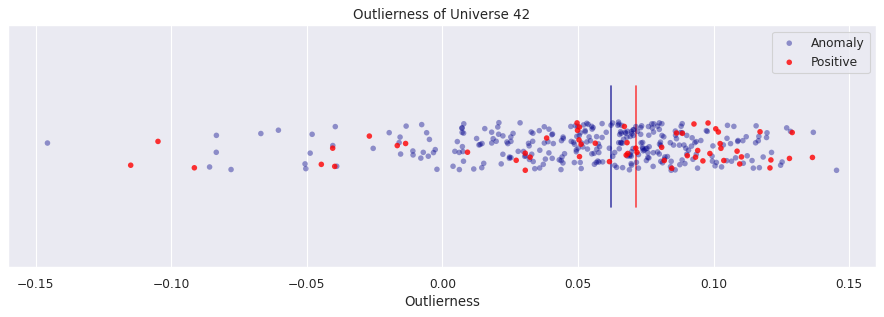

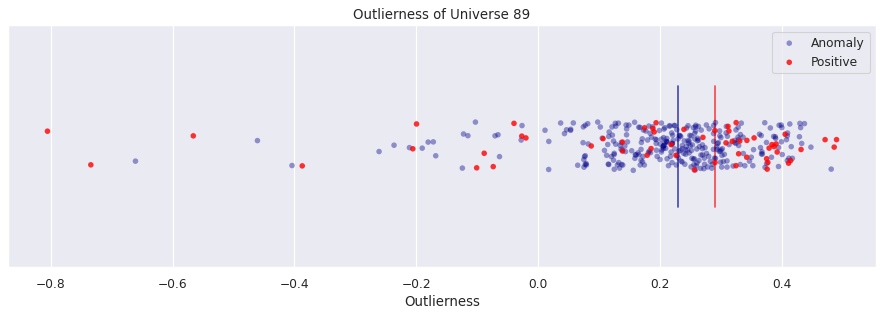

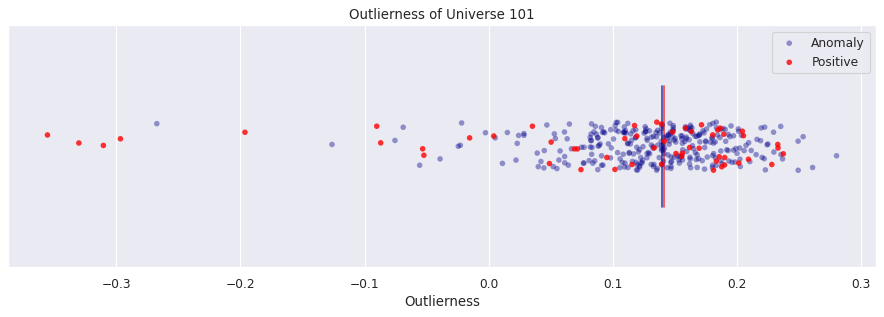

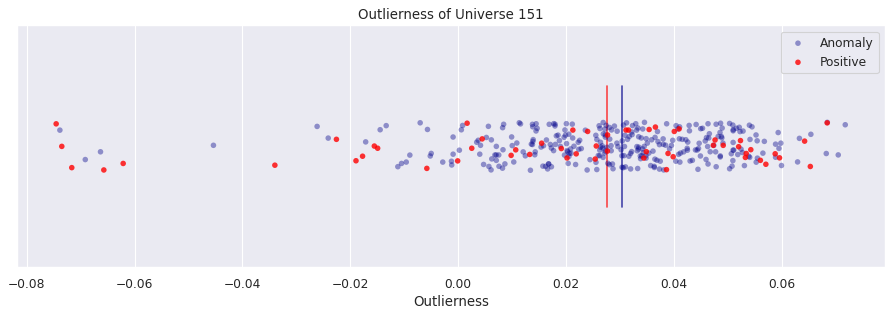

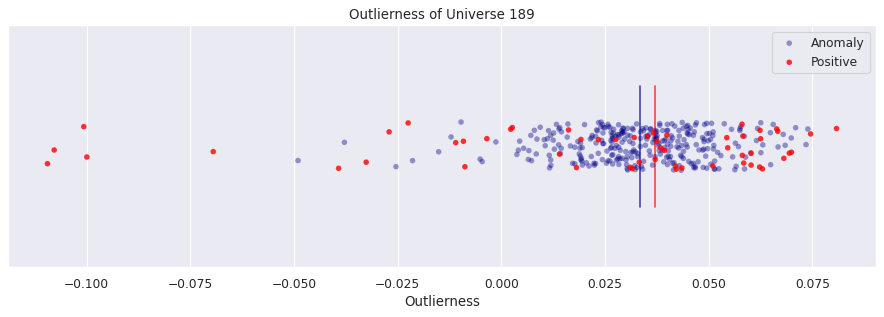

In [269]:
# Supervised outlierness visualization
vis = ToolsVisualization()

vis.outlierness_supervised(Y_collection, outlierness_pred)

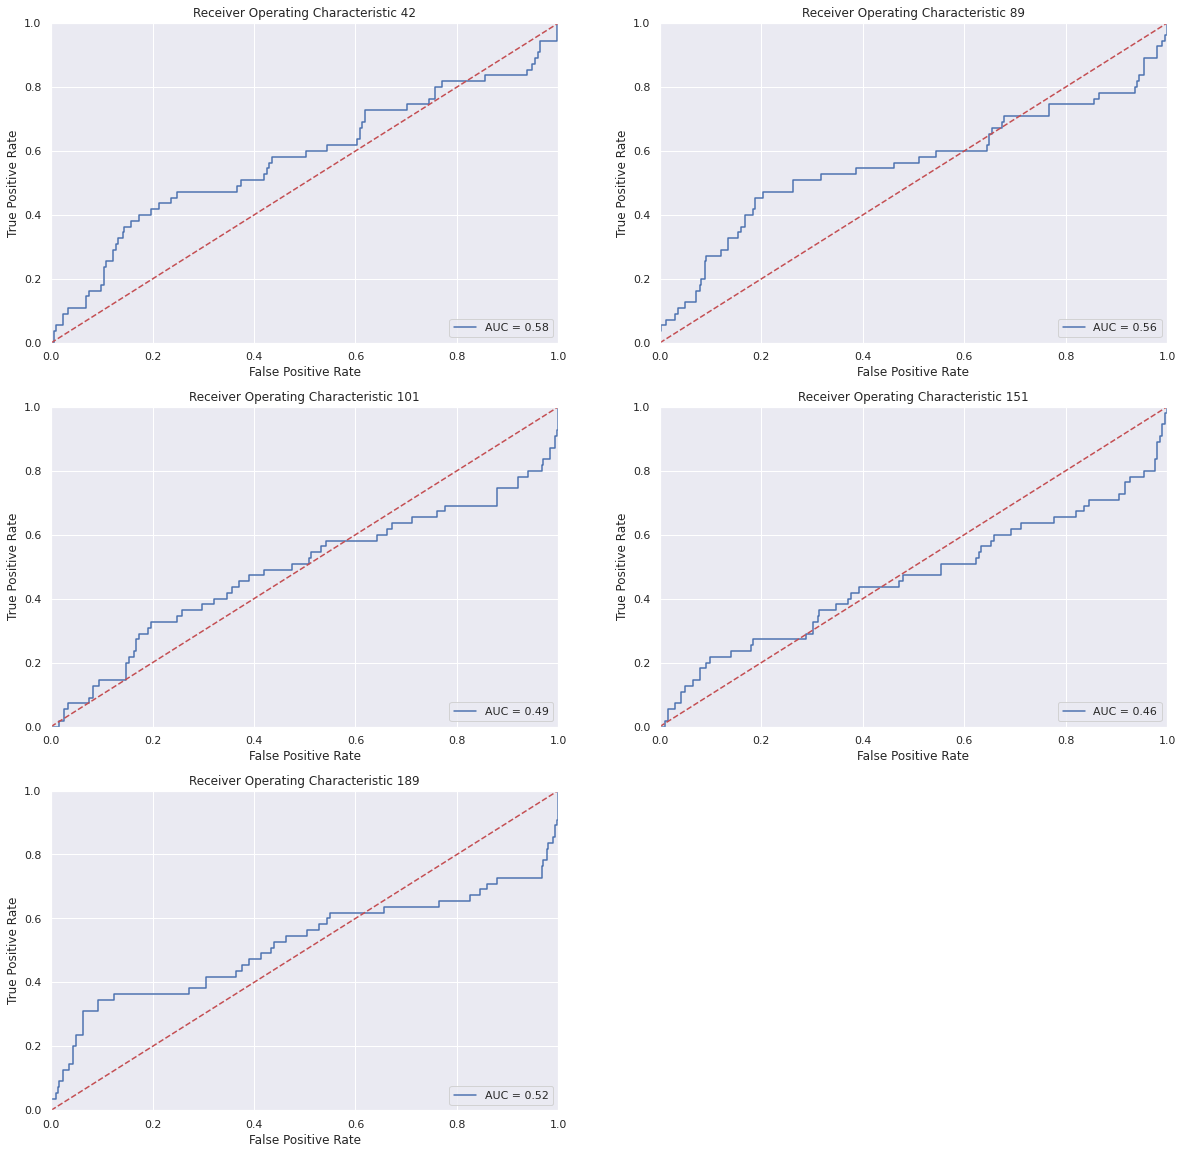

In [270]:
vis.ROC_plot_total(Y_collection, outlierness_pred, 1)

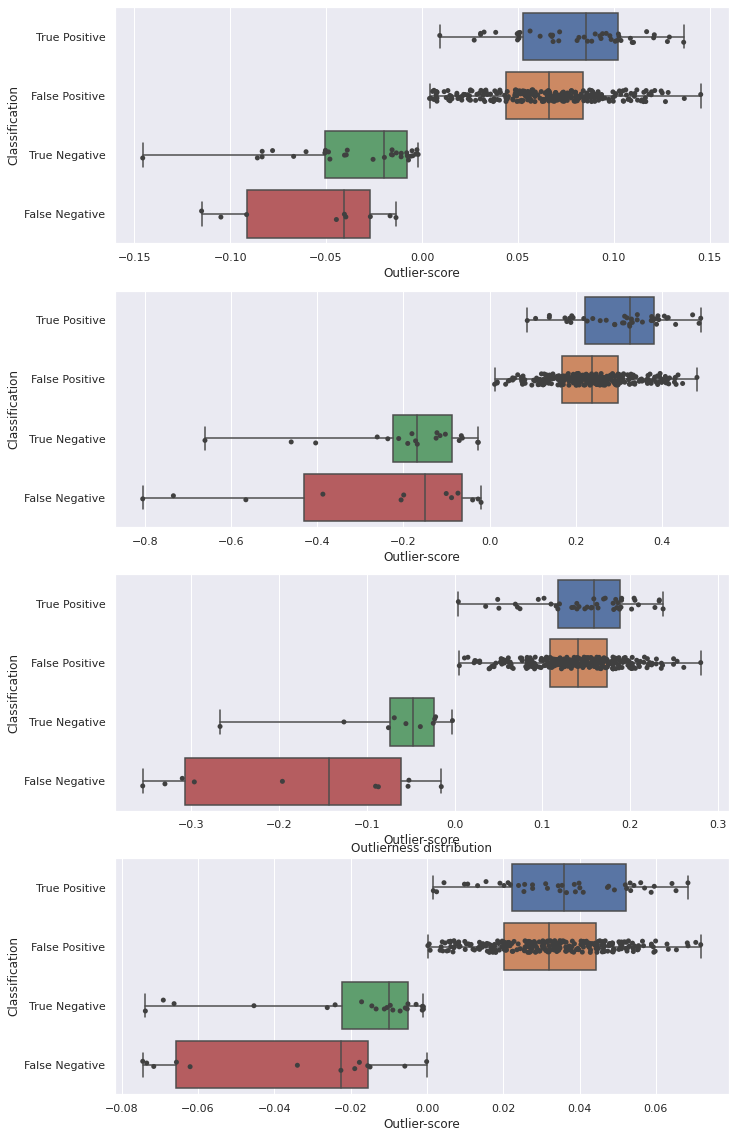

In [271]:
vis = ToolsVisualization()

vis.outlierness_plot_total(Y_collection, y_pred, outlierness_pred, normal=1, anomaly=-1)

**CONFUSION MATRIX**

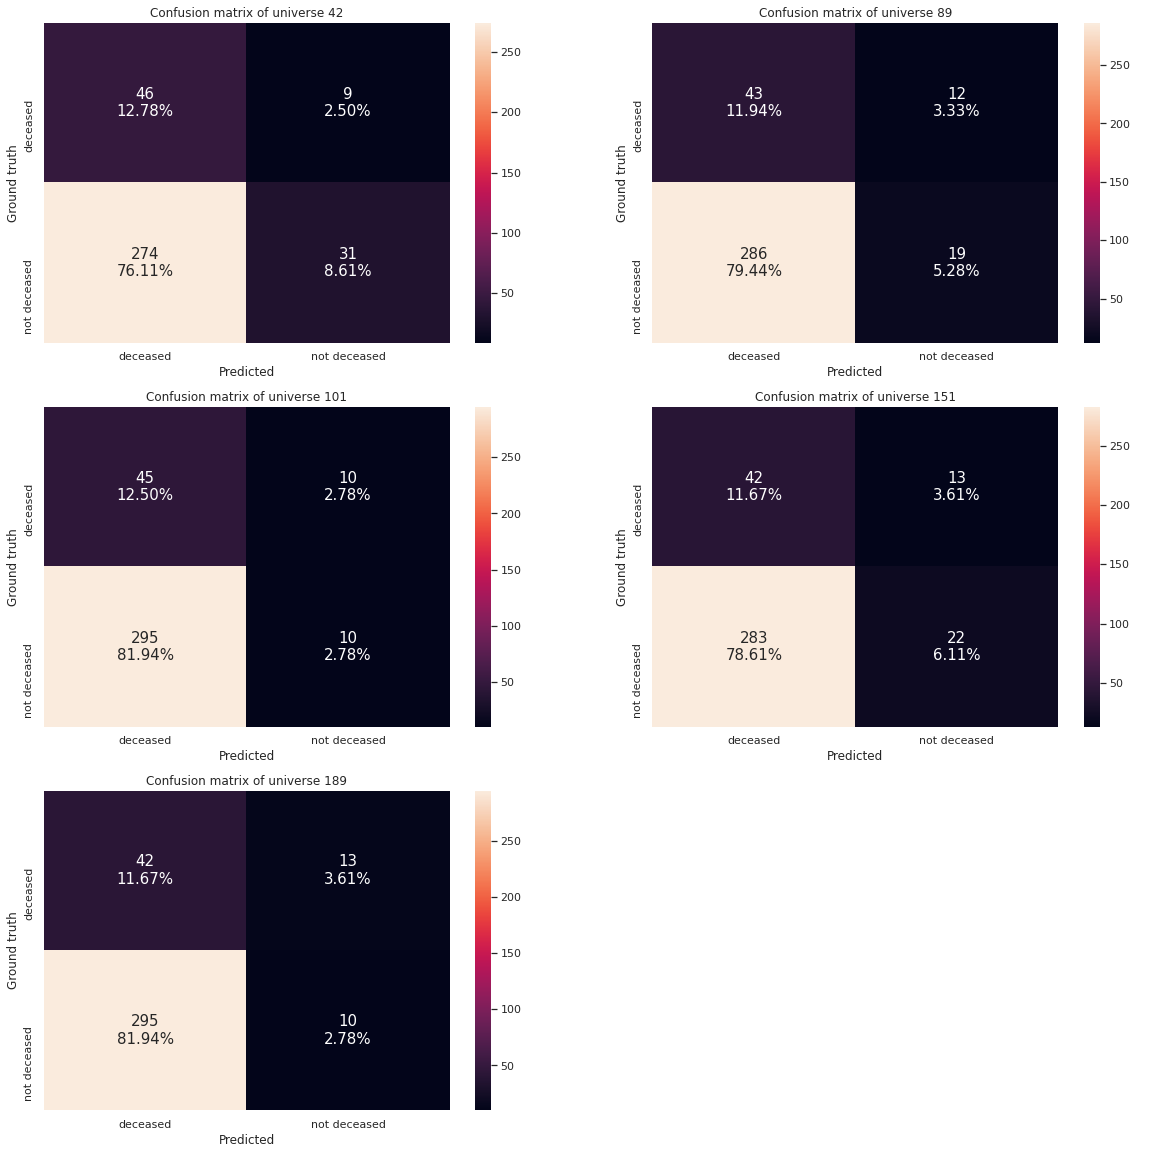

In [272]:
vis.confusion_matrix_plot_total(Y_collection, y_pred, [1, -1], normal='deceased',anomaly='not deceased')

**EVALUATION METRICS**

In [273]:
ev = tool.metric_evaluation(Y_collection, y_pred, outlierness_pred, 1)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Prediction      |   Pos Neg [42]  |   Pos Neg [89]  |  Pos Neg [101]  |  Pos Neg [151]  |  Pos Neg [189]  |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Positive        |       46 9      |       43 12     |       45 10     |       42 13     |       42 13     |
| Negative        |      274 31     |      286 19     |      295 10     |      283 22     |      295 10     |
| --------------- | --------------- | --------------- | --------------- | --------------- | --------------- |
| AUC             |      0.576*     |      0.560      |      0.487      |      0.463      |      0.519      |
| Accuracy        |      0.214*     |      0.172      |      0.153      |      0.178      |      0.144      |
| Precision       |      0.144*     |      0.131      |      0.132      |      0.129      |      0.125      |
| Sensitiv

In [274]:
for col in ev.columns:
    print(f'{col}\t Mean: {ev[col].mean()}\t Std: {ev[col].std()}')

AUC	 Mean: 0.5210849478390461	 Std: 0.04767707350488386
Accuracy	 Mean: 0.17222222222222222	 Std: 0.027003086243366083
Precision	 Mean: 0.13213237573436615	 Std: 0.007102656569918594
Sensitivity	 Mean: 0.7927272727272727	 Std: 0.03302891295379079
Specificity	 Mean: 0.06032786885245902	 Std: 0.029012225318857627
F1-score	 Mean: 0.22649562275943022	 Std: 0.01163866823712567


In [275]:
ev

,AUC,Accuracy,Precision,Sensitivity,Specificity,F1-score
42,0.575857,0.213889,0.143750,0.836364,0.101639,0.245333
89,0.560298,0.172222,0.130699,0.781818,0.062295,0.223958
101,0.487154,0.152778,0.132353,0.818182,0.032787,0.227848
151,0.462772,0.177778,0.129231,0.763636,0.072131,0.221053
189,0.519344,0.144444,0.124629,0.763636,0.032787,0.214286


### Default parameters

**Pipeline configuration:**

* <u>Feature filtering</u>
    * Features to keep (a priori knowledge): 
    * Filer method:
    * Outcome performance metric:
    * Columns to drop:

* <u>Row removal</u>
    * Discard quantile:

* <u>Hyperparameter optimization</u>
    * Parameters:
* <u>Prediction</u>
    * Cut-off value selection method:

In [148]:
pl = Pipeline(OneClassSVM(), X_collection, Y_collection, feature_keep = ['CD000MSEX', 'CD000FSEX', 'CD0000AGE', 'CTHSDXXTEMP', 'CTHSDXXSAT', 'CTHSDXXRATE'], f_filter ='var_ratio', f_perf = 'auc', parameters = {})

############# FILTERING #############

# ['med', 'med_mean', 'auc']
pl.feature_filtering(n_drop = 25)

############# ROW REMOVAL #############

outss = pl.row_removal(visual = 0)

############# MODEL FITTING #############

pl.fit()

############# MODEL PREDICTION (outlierness) #############

outlierness_pred = pl.outlierness()

############# MODEL PREDICTION #############

y_pred = pl.predict('auto')



 # Applying feature filtering:
	 Filtering mode: var_ratio
	 Outcome quality measure metric: auc


k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Best configuration (median difference):
 	 * Difference: 0.1694154301011983 
 	 * Filtering: var_ratio 
 	 * Removed features: 22
Best configuration (median difference) (mean universe):
 	 * Difference: 0.033883086020239664 
 	 * Filtering: var_ratio 
 	 * Removed features: 22
Best configuration (AUC):
 	 * AUC: 0.588021609538003  
 	 * Filtering: var_ratio 
 	 * Removed features: 23
Filtering applied. 23 columns removed based on var_ratio. Performace measured with auc.

 # Applying row removal:
	 Quantile (removal): 0.9


Universe 42:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 89:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 101:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 151:   0%|          | 0/5 [00:00<?, ?it/s]

Universe 189:   0%|          | 0/5 [00:00<?, ?it/s]


 # Fitting data...


Classifier fitting:   0%|          | 0/5 [00:00<?, ?it/s]


 # Processing outlierness...

 # Predicting labels:
	 Cutoff value selection method: auto

 # Processing outlierness...


**Outlierness visualization (supervised)**

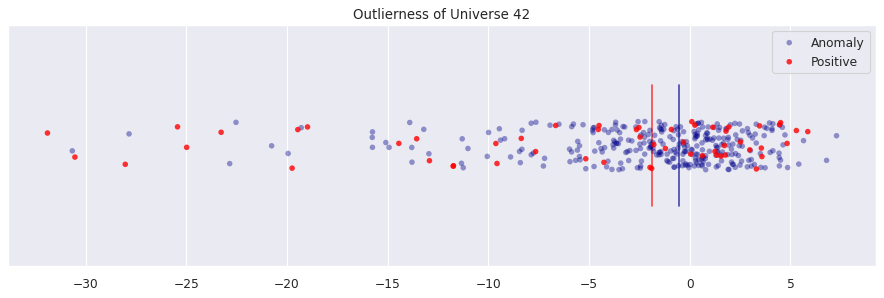

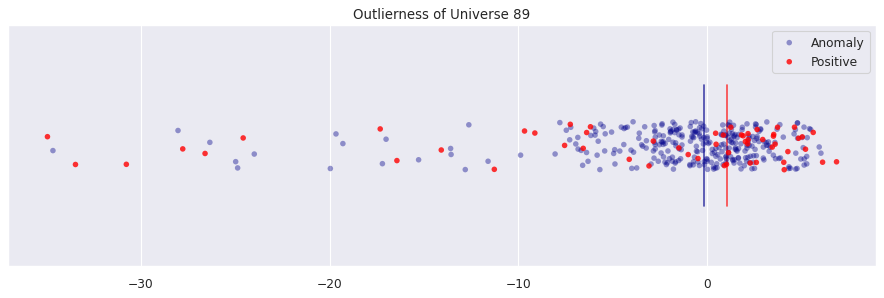

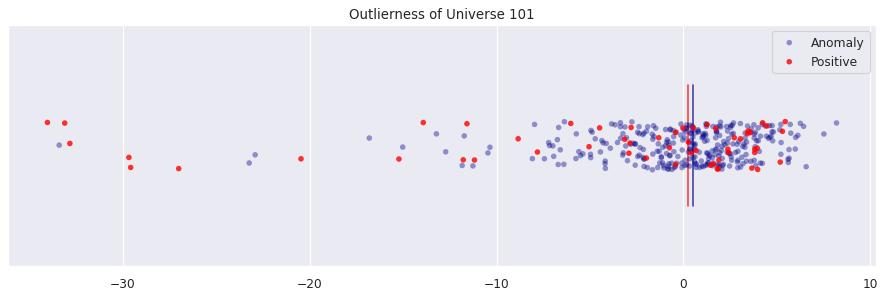

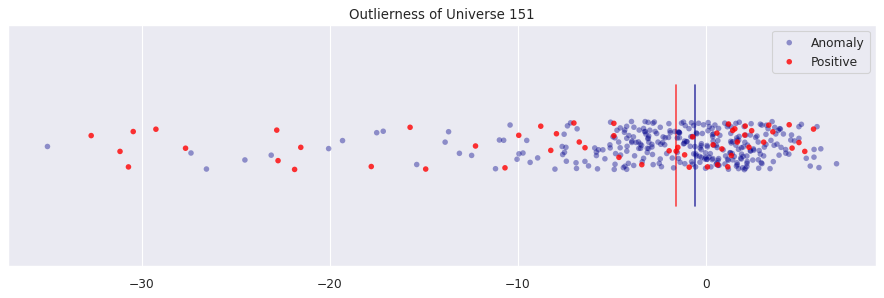

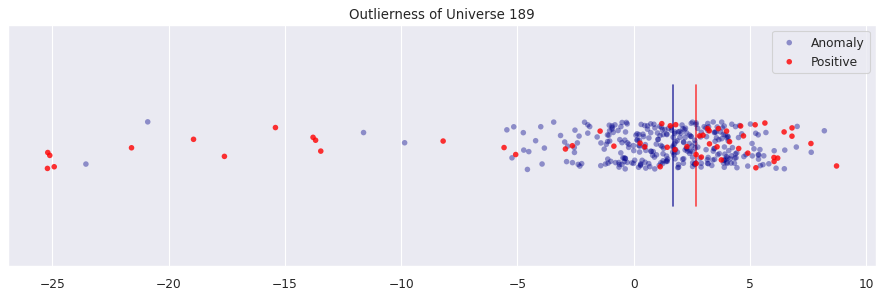

In [53]:
vis = ToolsVisualization()

vis.outlierness_supervised(Y_collection, outlierness_pred)

**ROC AUC**

<IPython.core.display.Javascript object>


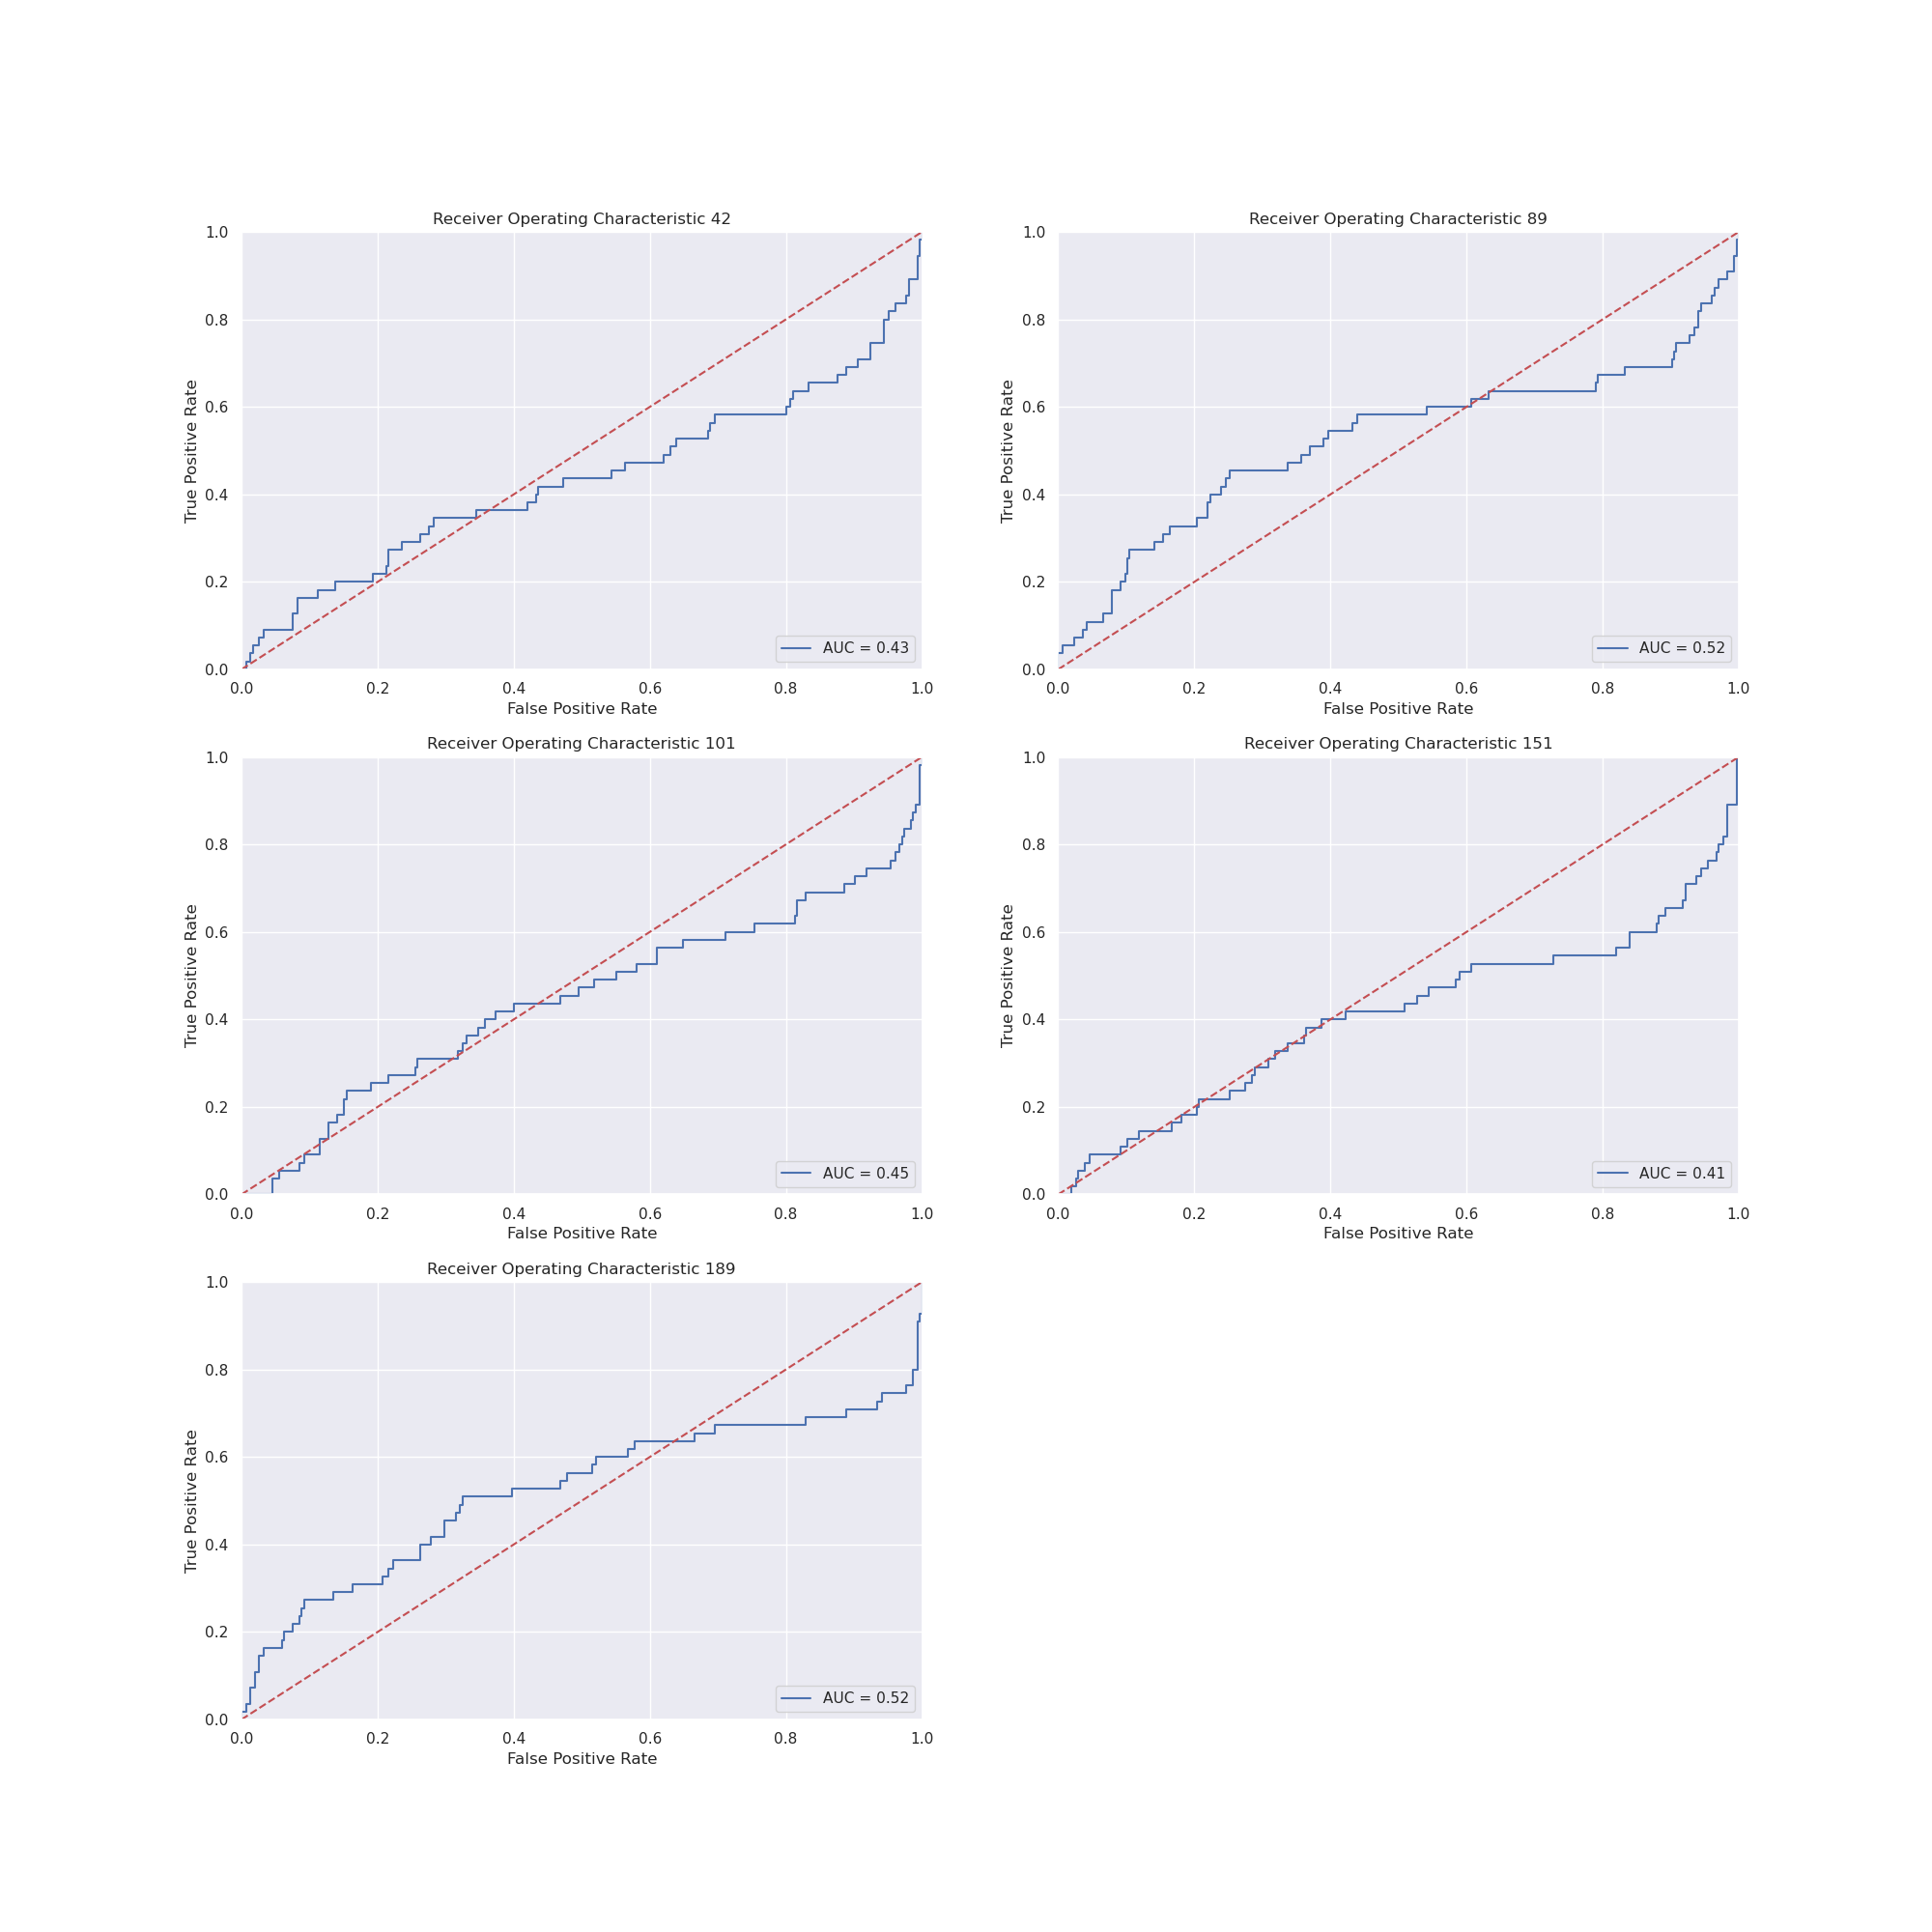

In [51]:
vis.ROC_plot_total(Y_collection, outlierness_pred, 1)

**CONFUSION MATRIX**

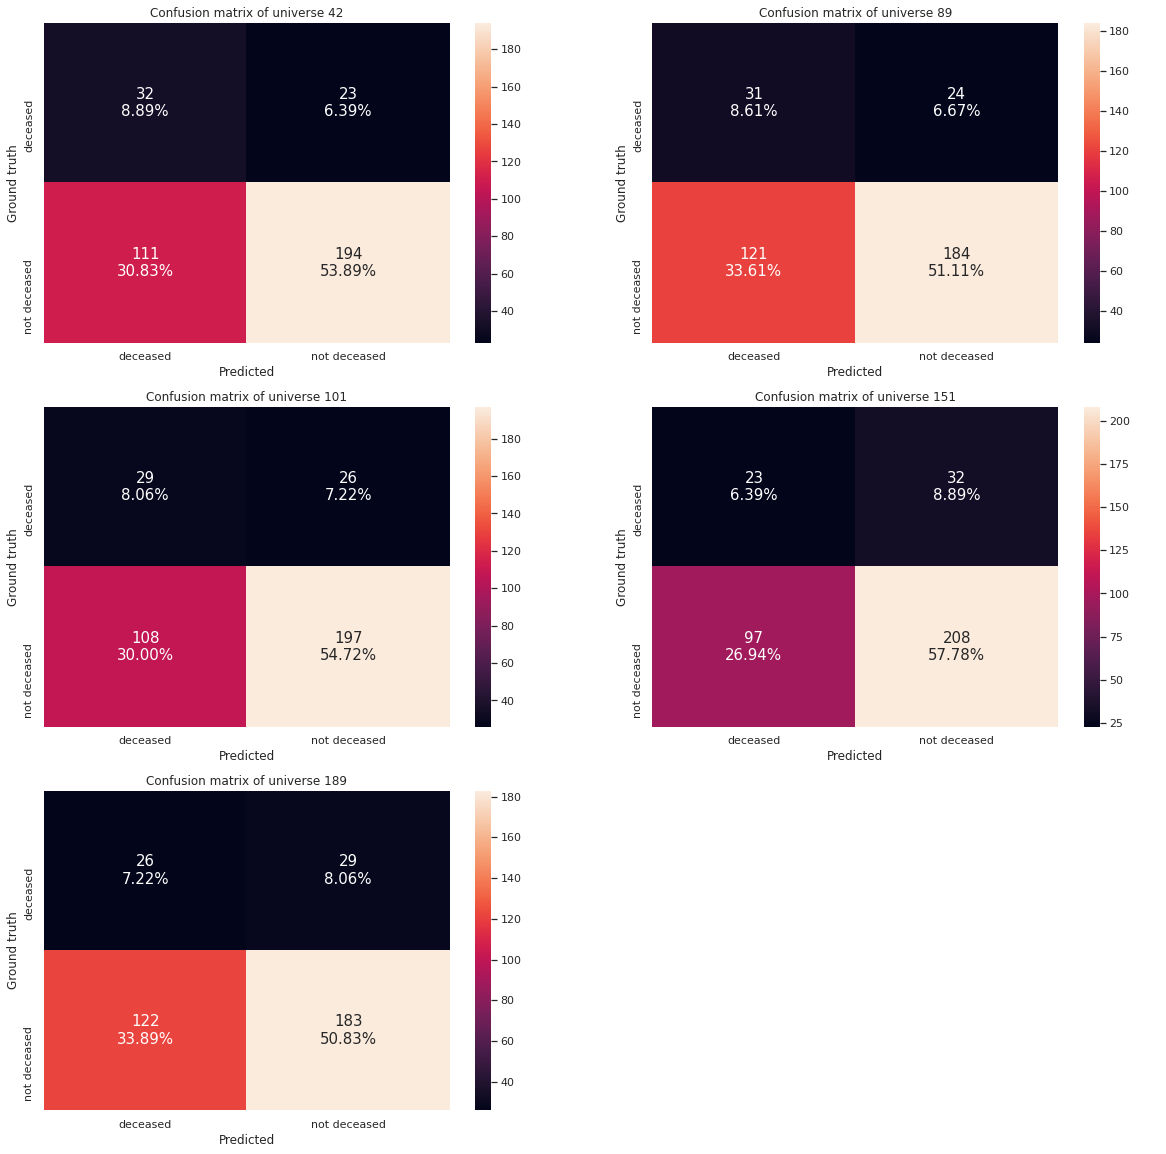

In [98]:
vis.confusion_matrix_plot_total(Y_collection, y_pred, [1, -1], normal='deceased',anomaly='not deceased')

**EVALUATION METRICS**

In [149]:
ev = tool.metric_evaluation(Y_collection, y_pred, outlierness_pred, 1)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Prediction      |   Pos Neg [42]  |   Pos Neg [89]  |  Pos Neg [101]  |  Pos Neg [151]  |  Pos Neg [189]  |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Positive        |       22 33     |       32 23     |       27 28     |       23 32     |       37 18     |
| Negative        |     133 172     |     147 158     |     179 126     |     129 176     |      222 83     |
| --------------- | --------------- | --------------- | --------------- | --------------- | --------------- |
| AUC             |      0.436      |      0.521*     |      0.441      |      0.405      |      0.512      |
| Accuracy        |      0.539      |      0.528      |      0.425      |      0.553*     |      0.333      |
| Precision       |      0.142      |      0.179*     |      0.131      |      0.151      |      0.143      |
| Sensitiv

**Precision-Recall Curve**

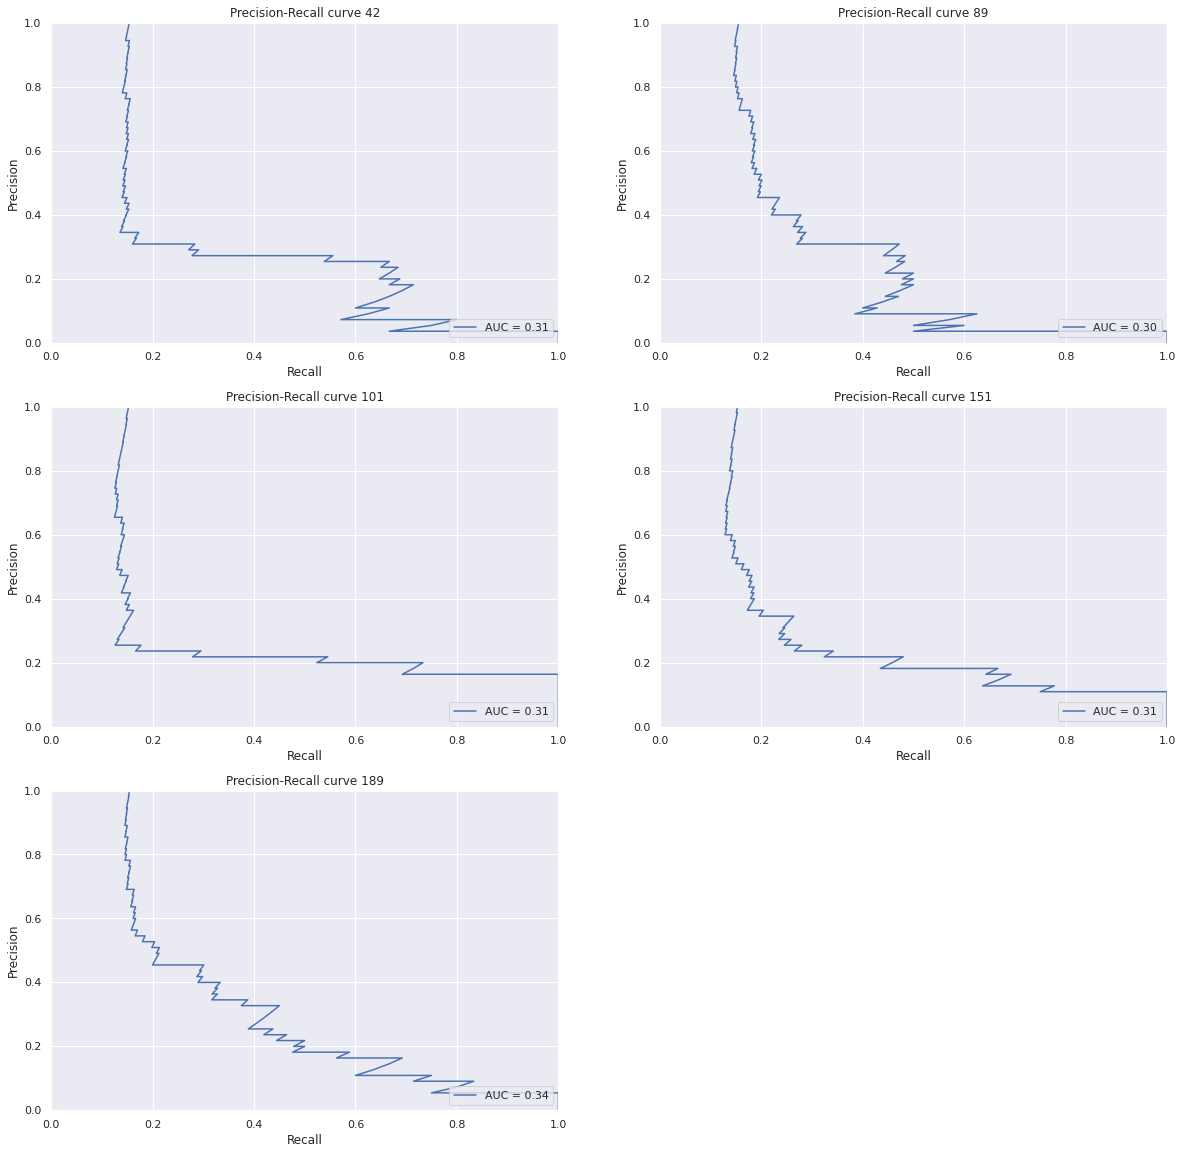

In [440]:
vis = ToolsVisualization()

vis.precision_recall_plot_total(Y_collection, outlierness_pred, 1)

## Autoencoder

**Pipeline configuration:**

* <u>Feature filtering</u>
    * Features to keep (a priori knowledge): 
    * Filer method:
    * Outcome performance metric:
    * Columns to drop:

* <u>Row removal</u>
    * Discard quantile:

* <u>Hyperparameter optimization</u>
    * Parameters:
* <u>Prediction</u>
    * Cut-off value selection method:

In [172]:
estimator_ae = auto_encoder.AutoEncoder(hidden_neurons=[32, 16, 32], contamination=0.5, epochs=100, verbose = 0)

pl = Pipeline(estimator_ae, X_collection, Y_collection, feature_keep = ['CD0000AGE', 'CTHSDXXSAT', 'CTHSDXXTEMP', 'CTHSDXXSAT', 'CTHSDXXRATE'], f_filter ='var_ratio', f_perf = 'auc', parameters = {})

############# FILTERING #############

# ['med', 'med_mean', 'auc']
pl.feature_filtering(n_drop = 10)

############# ROW REMOVAL #############

outlierness_row = pl.row_removal(visual = 0)

############# MODEL FITTING #############

pl.fit()

############# MODEL PREDICTION (outlierness) #############

outlierness_pred = pl.outlierness()

############# MODEL PREDICTION #############

y_pred = pl.predict()



 # Applying feature filtering:
	 Filtering mode: var_ratio
	 Outcome quality measure metric: auc


k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Universe 42
Best configuration (median difference):
 	 * Difference: 0.02619341861658922 
 	 * Filtering: var_ratio 
 	 * Removed features: 0
Best configuration (median difference) (mean universe):
 	 * Difference: 0.005238683723317844 
 	 * Filtering: var_ratio 
 	 * Removed features: 0
Best configuration (AUC):
 	 * AUC: 0.5653759820426487  
 	 * Filtering: var_ratio 
 	 * Removed features: 8


k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Universe 89
Best configuration (median difference):
 	 * Difference: 0.04000448865118275 
 	 * Filtering: var_ratio 
 	 * Removed features: 9
Best configuration (median difference) (mean universe):
 	 * Difference: 0.00800089773023655 
 	 * Filtering: var_ratio 
 	 * Removed features: 9
Best configuration (AUC):
 	 * AUC: 0.5707070707070706  
 	 * Filtering: var_ratio 
 	 * Removed features: 8


k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Universe 101
Best configuration (median difference):
 	 * Difference: 0.04000448865118275 
 	 * Filtering: var_ratio 
 	 * Removed features: 9
Best configuration (median difference) (mean universe):
 	 * Difference: 0.00800089773023655 
 	 * Filtering: var_ratio 
 	 * Removed features: 9
Best configuration (AUC):
 	 * AUC: 0.5866244411326379  
 	 * Filtering: var_ratio 
 	 * Removed features: 9


k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Universe 151
Best configuration (median difference):
 	 * Difference: 0.04000448865118275 
 	 * Filtering: var_ratio 
 	 * Removed features: 9
Best configuration (median difference) (mean universe):
 	 * Difference: 0.00800089773023655 
 	 * Filtering: var_ratio 
 	 * Removed features: 9
Best configuration (AUC):
 	 * AUC: 0.5866244411326379  
 	 * Filtering: var_ratio 
 	 * Removed features: 9


k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/10 [00:00<?, ?it/s]

Universe 189
Best configuration (median difference):
 	 * Difference: 0.04000448865118275 
 	 * Filtering: var_ratio 
 	 * Removed features: 9
Best configuration (median difference) (mean universe):
 	 * Difference: 0.00800089773023655 
 	 * Filtering: var_ratio 
 	 * Removed features: 9
Best configuration (AUC):
 	 * AUC: 0.6506630086877  
 	 * Filtering: var_ratio 
 	 * Removed features: 9
Filtering applied. 9 columns removed based on var_ratio. Performace measured with auc.

 # Applying row removal:
	 Quantile (removal): 0.9


Universe 42:   0%|          | 0/5 [00:00<?, ?it/s]

Rows removed in universe 42: 25


Universe 89:   0%|          | 0/5 [00:00<?, ?it/s]

Rows removed in universe 89: 25


Universe 101:   0%|          | 0/5 [00:00<?, ?it/s]

Rows removed in universe 101: 25


Universe 151:   0%|          | 0/5 [00:00<?, ?it/s]

Rows removed in universe 151: 25


Universe 189:   0%|          | 0/5 [00:00<?, ?it/s]

Rows removed in universe 189: 25

 # Fitting data...


Classifier fitting:   0%|          | 0/5 [00:00<?, ?it/s]


 # Processing outlierness...

 # Predicting labels:
	 Cutoff value selection method: ROC

 # Processing outlierness...


In [182]:
str(pl._cl_dict[42])

"AutoEncoder(batch_size=32, contamination=0.5, dropout_rate=0.2, epochs=100,\n      hidden_activation='relu', hidden_neurons=[32, 16, 32],\n      l2_regularizer=0.1,\n      loss=<function mean_squared_error at 0x7f6154068ee0>,\n      optimizer='adam', output_activation='sigmoid', preprocessing=True,\n      random_state=None, validation_size=0.1, verbose=0)"

**Outlierness visualization (supervised)**

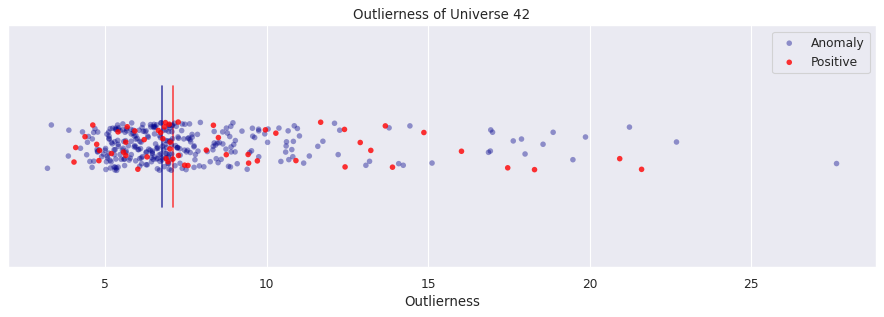

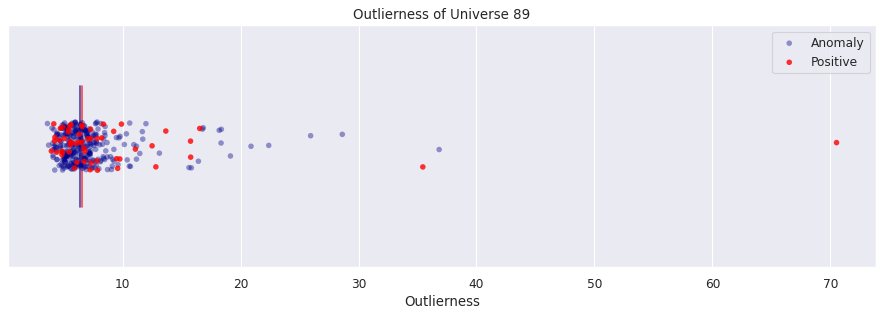

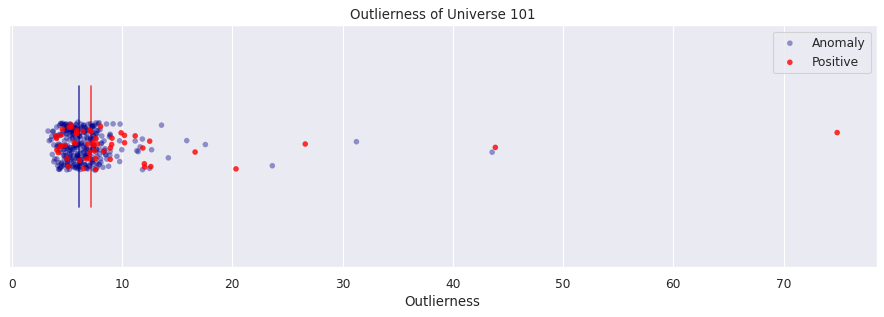

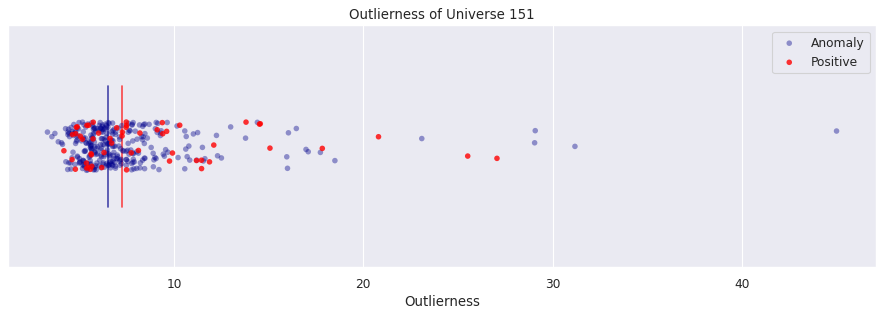

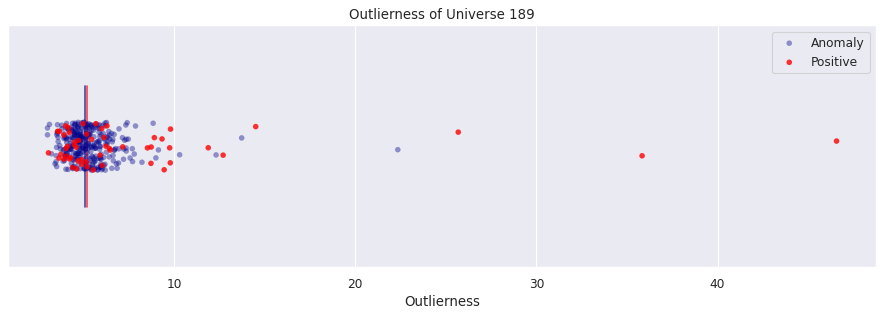

In [173]:
vis = ToolsVisualization()

vis.outlierness_supervised(Y_collection, outlierness_pred)

**ROC**

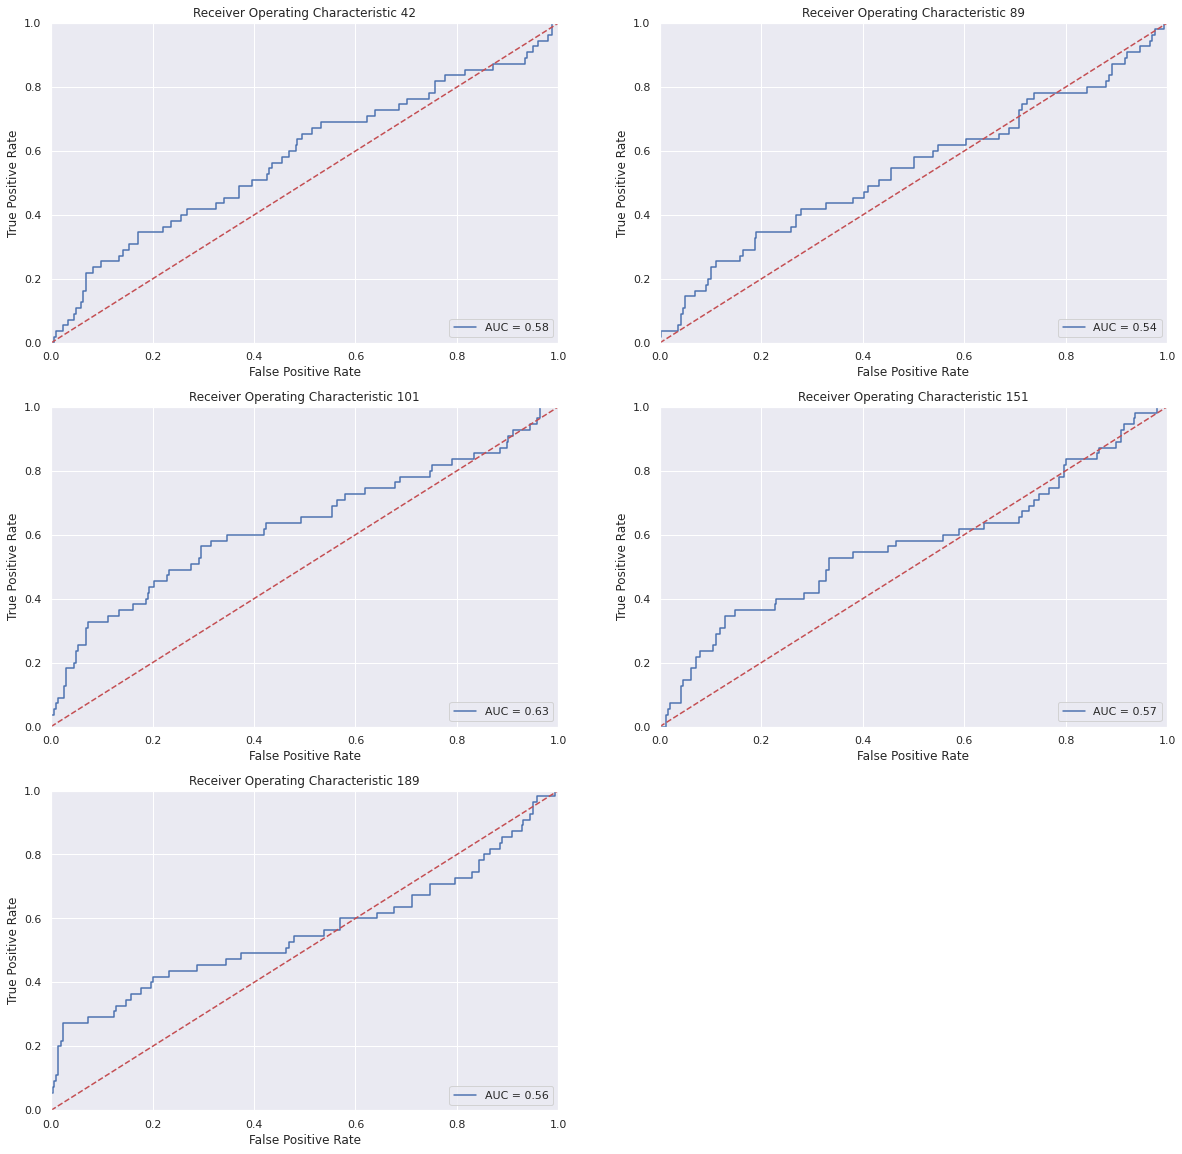

In [174]:
vis = ToolsVisualization()

vis.ROC_plot_total(Y_collection, outlierness_pred, 1)

**Precision-Recall Curve**

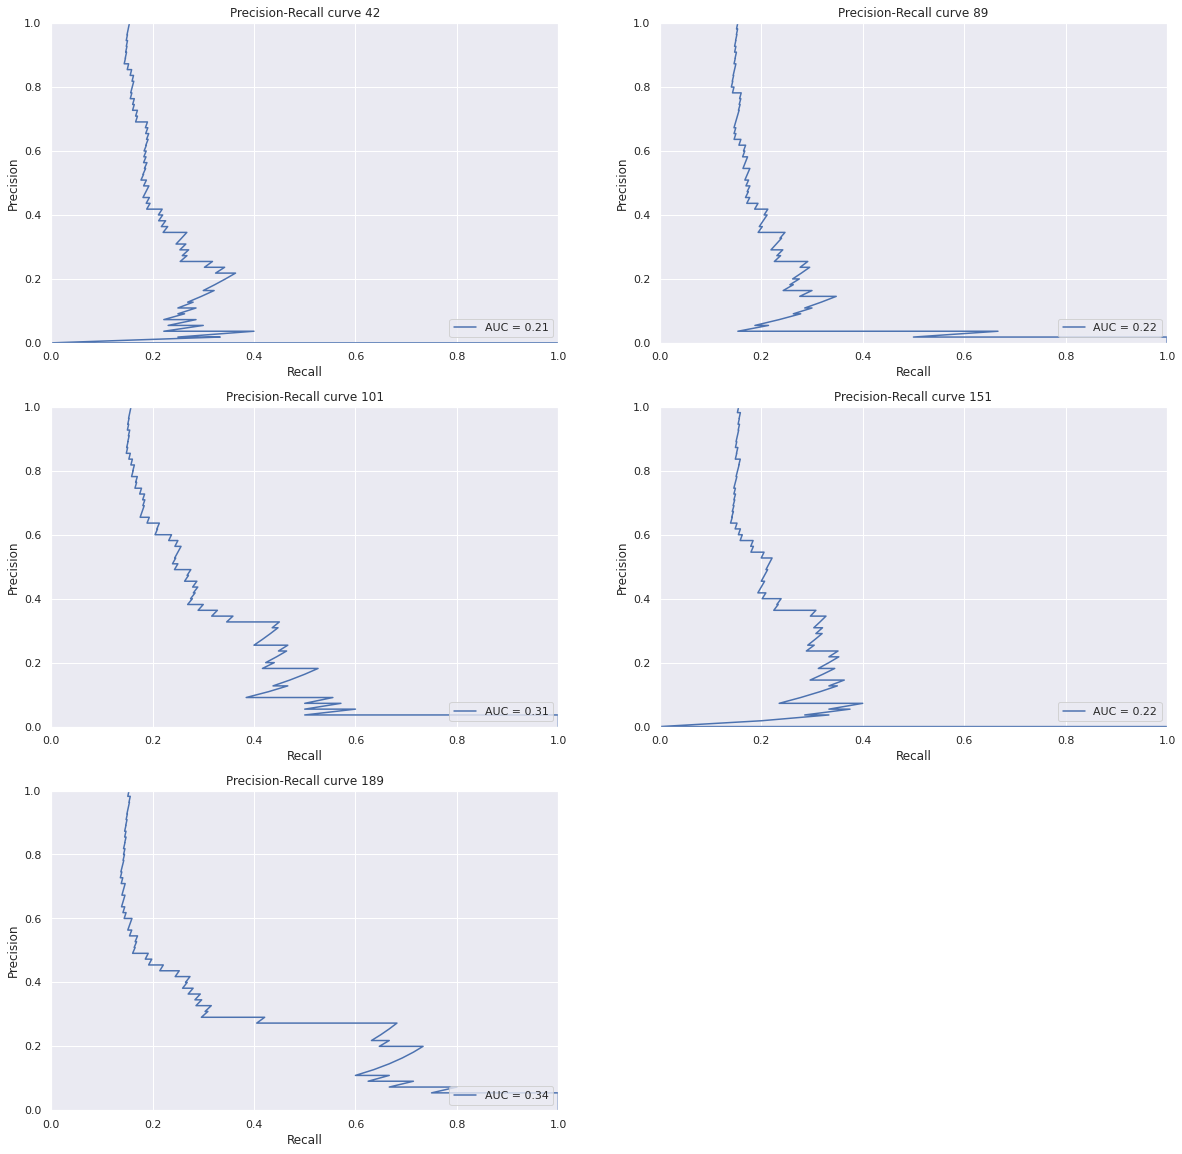

In [175]:
vis = ToolsVisualization()

vis.precision_recall_plot_total(Y_collection, outlierness_pred, 1)

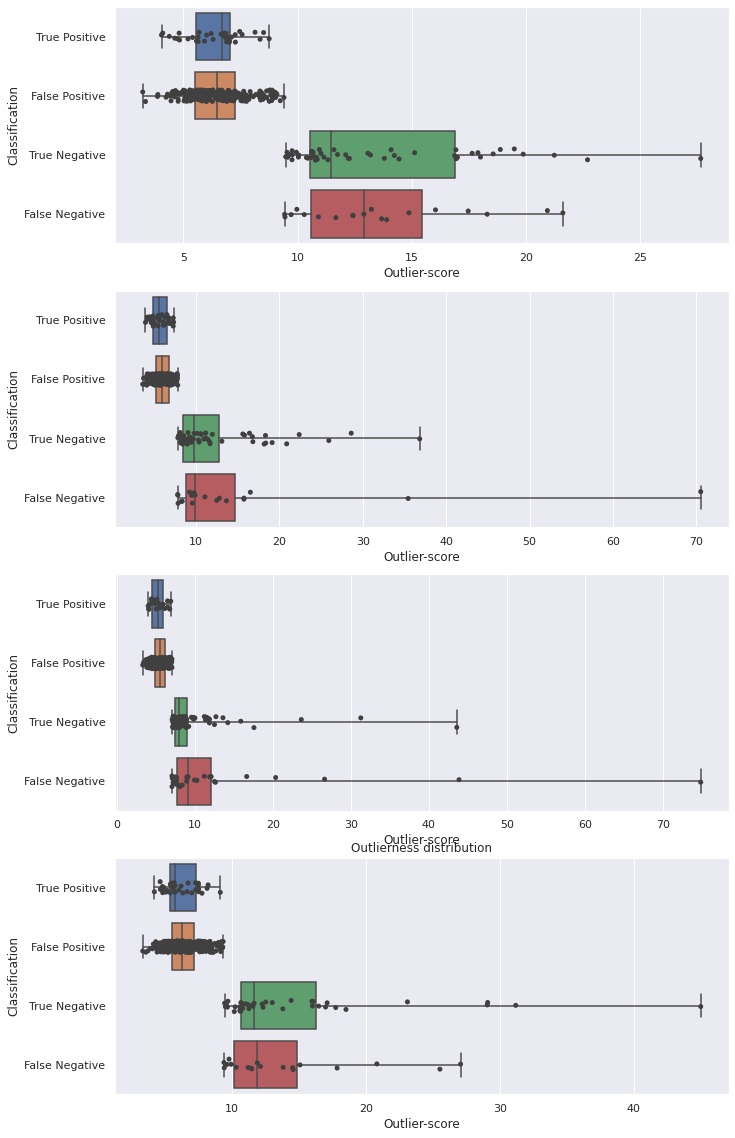

In [244]:
vis = ToolsVisualization()

vis.outlierness_plot_total(Y_collection, y_pred, outlierness_pred, normal=1, anomaly=-1)

**CONFUSION MATRIX**

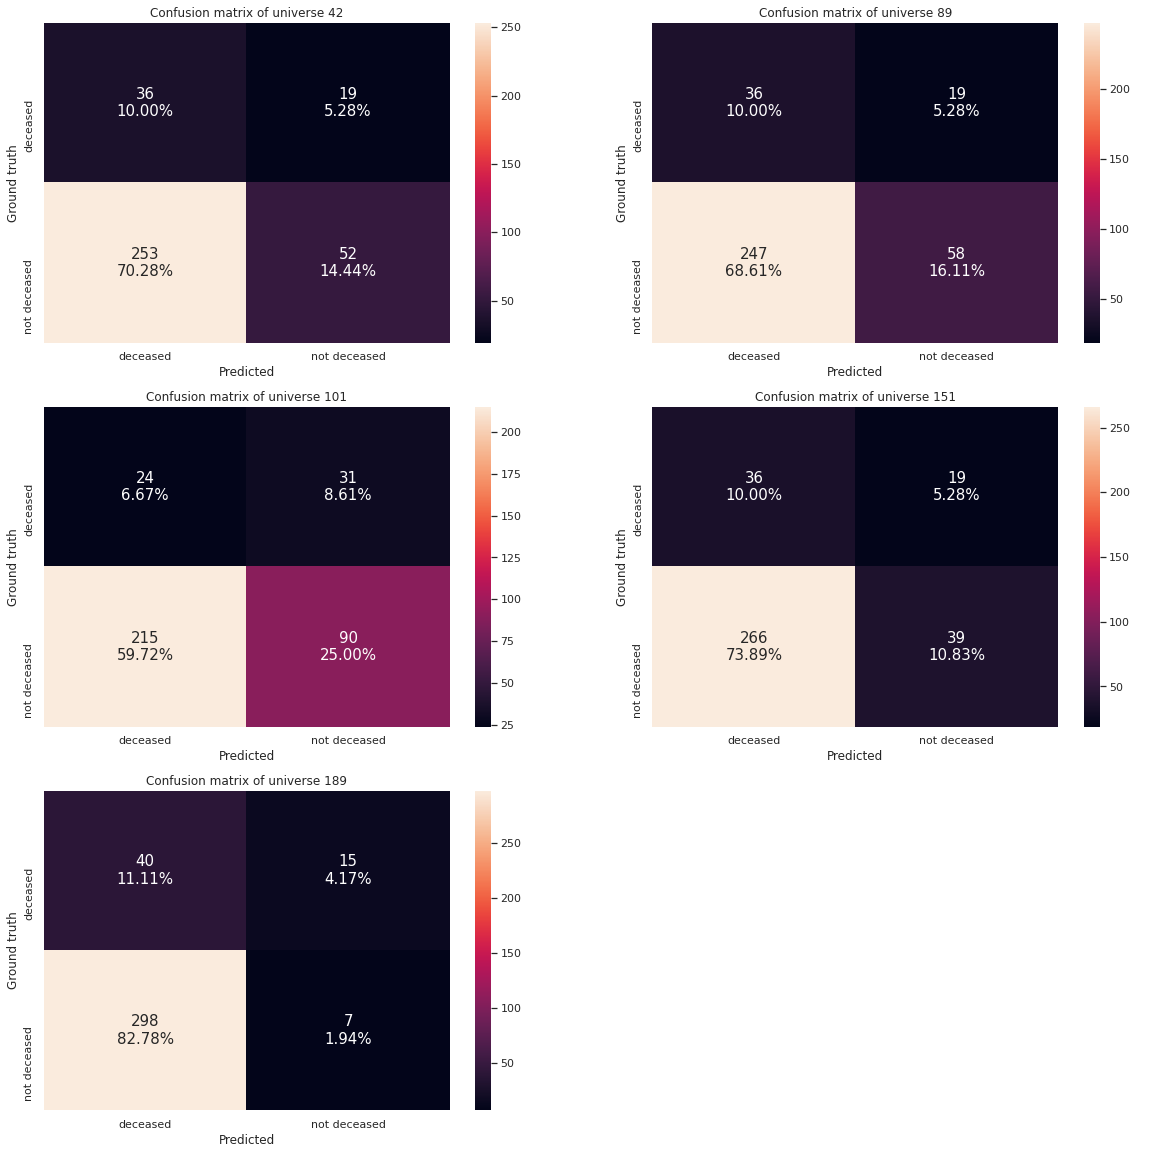

In [257]:
vis.confusion_matrix_plot_total(Y_collection, y_pred, [1, -1], normal='deceased',anomaly='not deceased')

**EVALUATION METRICS**

In [177]:
ev = tool.metric_evaluation(Y_collection, y_pred, outlierness_pred, 1)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Prediction      |   Pos Neg [42]  |   Pos Neg [89]  |  Pos Neg [101]  |  Pos Neg [151]  |  Pos Neg [189]  |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Positive        |       36 19     |       36 19     |       24 31     |       36 19     |       40 15     |
| Negative        |      253 52     |      247 58     |      215 90     |      266 39     |      298 7      |
| --------------- | --------------- | --------------- | --------------- | --------------- | --------------- |
| AUC             |      0.579      |      0.544      |      0.632*     |      0.567      |      0.558      |
| Accuracy        |      0.244      |      0.261      |      0.317*     |      0.208      |      0.131      |
| Precision       |      0.125      |      0.127*     |      0.100      |      0.119      |      0.118      |
| Sensitiv

In [256]:
for col in ev.columns:
    print(f'{col}\t Mean: {ev[col].mean()}\t Std: {ev[col].std()}')

AUC	 Mean: 0.576154992548435	 Std: 0.03396585093406641
Accuracy	 Mean: 0.2322222222222222	 Std: 0.06895941730153976
Precision	 Mean: 0.11794857158703442	 Std: 0.01047135899775964
Sensitivity	 Mean: 0.6254545454545454	 Std: 0.11029637009529529
Specificity	 Mean: 0.16131147540983606	 Std: 0.09883492218639338
F1-score	 Mean: 0.1981656792837926	 Std: 0.020025759155814553


In [258]:
ev

,AUC,Accuracy,Precision,Sensitivity,Specificity,F1-score
42,0.579493,0.244444,0.124567,0.654545,0.170492,0.209302
89,0.543607,0.261111,0.127208,0.654545,0.190164,0.213018
101,0.632191,0.316667,0.100418,0.436364,0.295082,0.163265
151,0.567452,0.208333,0.119205,0.654545,0.127869,0.201681
189,0.558033,0.130556,0.118343,0.727273,0.022951,0.203562


## LOF

In [259]:
lof_parameters= {
    'n_neighbors': np.arange(start=5, stop=20, step=1)
}

pl = Pipeline(lof.LOF(n_neighbors = 15), X_collection, Y_collection, feature_keep = ['CD0000AGE', 'CTHSDXXSAT', 'CTHSDXXTEMP', 'CTHSDXXSAT', 'CTHSDXXRATE'], f_filter ='var_ratio', f_perf='auc', parameters=lof_parameters)

############# FILTERING #############
# ['med', 'med_mean', 'auc']

# pl._fil = 'var_ratio'
pl.feature_filtering(n_drop = 25)

############# ROW REMOVAL #############

outss = pl.row_removal(visual = 0)

############# HYPERPARAMETER OPTIMIZATION #############


# Results made by filtering with variance RATIO (15 drop)

pl.hyperparameter_optimization()

############# MODEL FITTING #############

pl.fit()

############# MODEL PREDICTION (outlierness) #############

outlierness_pred = pl.outlierness()

############# MODEL PREDICTION #############

y_pred = pl.predict('ROC')



 # Applying feature filtering:
	 Filtering mode: var_ratio
	 Outcome quality measure metric: auc


k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Universe 42
Best configuration (median difference):
 	 * Difference: 0.0026174921805201257 
 	 * Filtering: var_ratio 
 	 * Removed features: 24
Best configuration (median difference) (mean universe):
 	 * Difference: 0.0005234984361040251 
 	 * Filtering: var_ratio 
 	 * Removed features: 24
Best configuration (AUC):
 	 * AUC: 0.7543022820800598  
 	 * Filtering: var_ratio 
 	 * Removed features: 15


k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Universe 89
Best configuration (median difference):
 	 * Difference: 0.0026174921805201257 
 	 * Filtering: var_ratio 
 	 * Removed features: 24
Best configuration (median difference) (mean universe):
 	 * Difference: 0.0005234984361040251 
 	 * Filtering: var_ratio 
 	 * Removed features: 24
Best configuration (AUC):
 	 * AUC: 0.7543022820800598  
 	 * Filtering: var_ratio 
 	 * Removed features: 15


k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Universe 101
Best configuration (median difference):
 	 * Difference: 0.0026174921805201257 
 	 * Filtering: var_ratio 
 	 * Removed features: 24
Best configuration (median difference) (mean universe):
 	 * Difference: 0.0005234984361040251 
 	 * Filtering: var_ratio 
 	 * Removed features: 24
Best configuration (AUC):
 	 * AUC: 0.7543022820800598  
 	 * Filtering: var_ratio 
 	 * Removed features: 15


k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Universe 151
Best configuration (median difference):
 	 * Difference: 0.0026174921805201257 
 	 * Filtering: var_ratio 
 	 * Removed features: 24
Best configuration (median difference) (mean universe):
 	 * Difference: 0.0005234984361040251 
 	 * Filtering: var_ratio 
 	 * Removed features: 24
Best configuration (AUC):
 	 * AUC: 0.7543022820800598  
 	 * Filtering: var_ratio 
 	 * Removed features: 15


k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Feature filtering:   0%|          | 0/25 [00:00<?, ?it/s]

Universe 189
Best configuration (median difference):
 	 * Difference: 0.0026174921805201257 
 	 * Filtering: var_ratio 
 	 * Removed features: 24
Best configuration (median difference) (mean universe):
 	 * Difference: 0.0005234984361040251 
 	 * Filtering: var_ratio 
 	 * Removed features: 24
Best configuration (AUC):
 	 * AUC: 0.7659807956104252  
 	 * Filtering: var_ratio 
 	 * Removed features: 12
Filtering applied. 12 columns removed based on var_ratio. Performace measured with auc.

 # Applying row removal:
	 Quantile (removal): 0.9


Universe 42:   0%|          | 0/5 [00:00<?, ?it/s]

Rows removed in universe 42: 25


Universe 89:   0%|          | 0/5 [00:00<?, ?it/s]

Rows removed in universe 89: 25


Universe 101:   0%|          | 0/5 [00:00<?, ?it/s]

Rows removed in universe 101: 25


Universe 151:   0%|          | 0/5 [00:00<?, ?it/s]

Rows removed in universe 151: 25


Universe 189:   0%|          | 0/5 [00:00<?, ?it/s]

Rows removed in universe 189: 25

 # Optimizing hyperparameters: 
	 Parameters to optimize: 


Hyperparameter optimization:   0%|          | 0/5 [00:00<?, ?it/s]

Outer loop folds: 1/5
Outer loop folds: 2/5
Outer loop folds: 3/5
Outer loop folds: 4/5
Outer loop folds: 5/5
Metrics: f1-score
Summary:
Outer fold nº1.
Parameters (best of cv): {'n_neighbors': 15}
Score (best of cv): 0.766±0.0044
Score (outer): 0.7245

Outer fold nº2.
Parameters (best of cv): {'n_neighbors': 19}
Score (best of cv): 0.775±0.0031
Score (outer): 0.7005

Outer fold nº3.
Parameters (best of cv): {'n_neighbors': 17}
Score (best of cv): 0.746±0.0035
Score (outer): 0.8116

Outer fold nº4.
Parameters (best of cv): {'n_neighbors': 19}
Score (best of cv): 0.76±0.0015
Score (outer): 0.7891

Outer fold nº5.
Parameters (best of cv): {'n_neighbors': 19}
Score (best of cv): 0.776±0.005
Score (outer): 0.7007

Parameters.
{'algorithm': 'auto', 'contamination': 0.1, 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 17, 'p': 2}

Outer loop folds: 1/5
Outer loop folds: 2/5
Outer loop folds: 3/5
Outer loop folds: 4/5
Outer loop folds: 5/5
Metrics: f

Classifier fitting:   0%|          | 0/5 [00:00<?, ?it/s]


 # Processing outlierness...

 # Predicting labels:
	 Cutoff value selection method: ROC

 # Processing outlierness...


**Local outlierness within train samples**

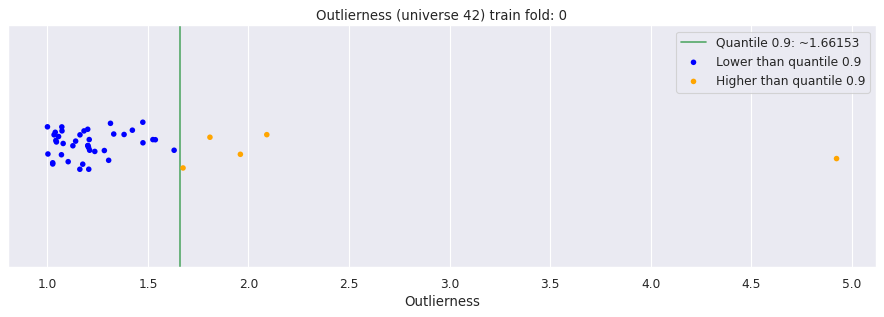

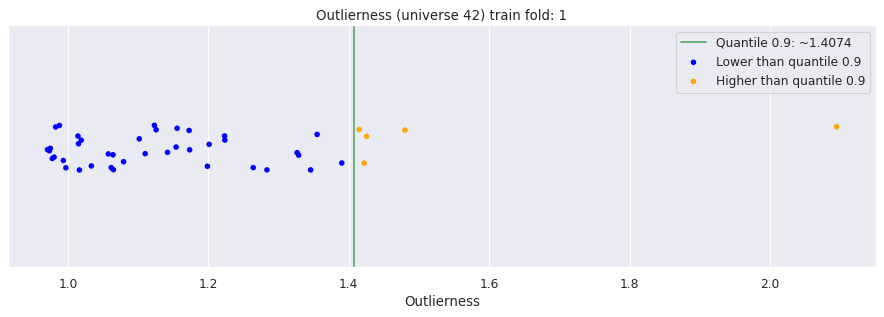

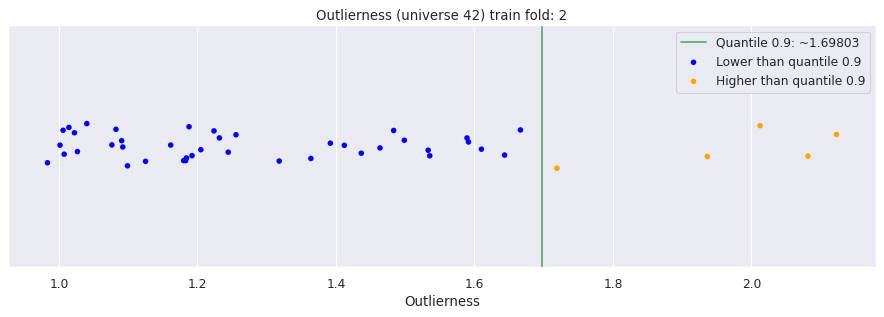

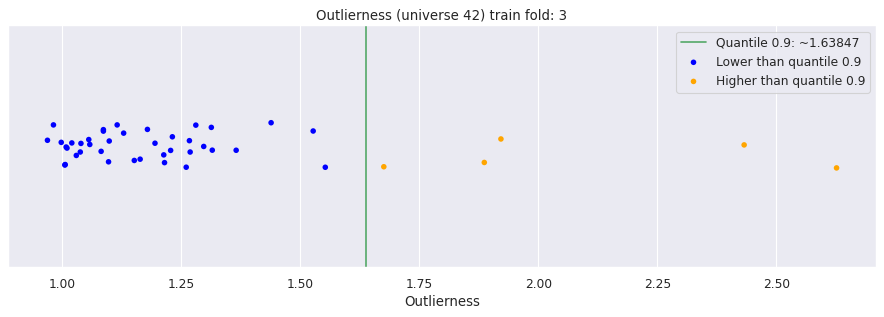

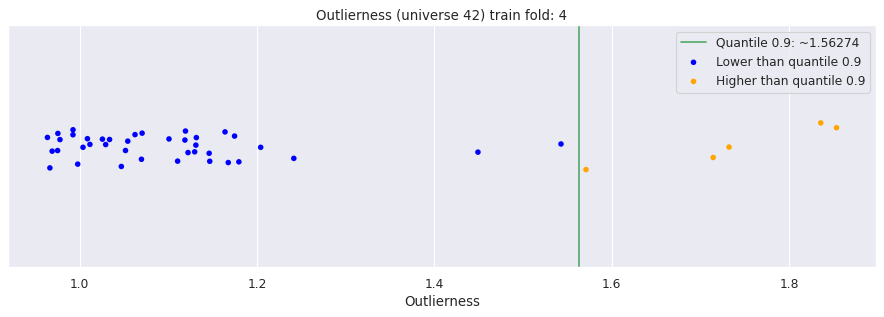

In [260]:
vis.outlierness_unsupervised(outss[0], quantile=0.9, title='Outlierness (universe 42) train fold: ')

**Outlierness visualization (supervised)**

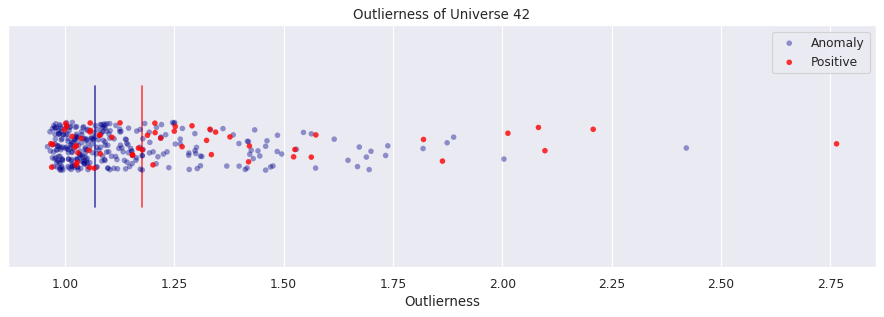

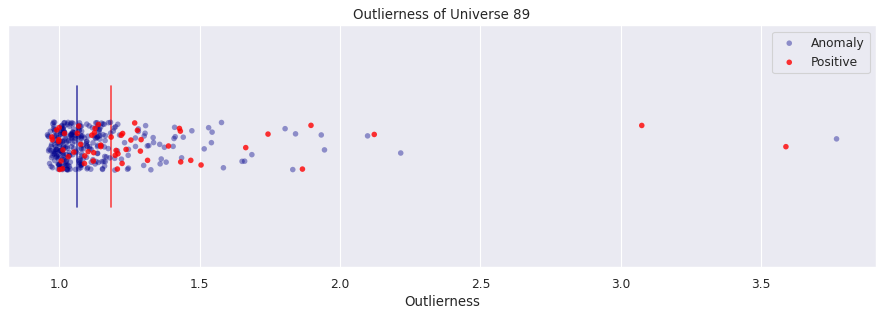

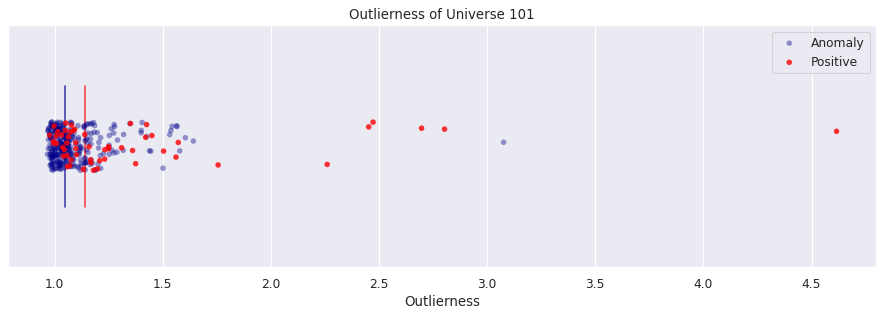

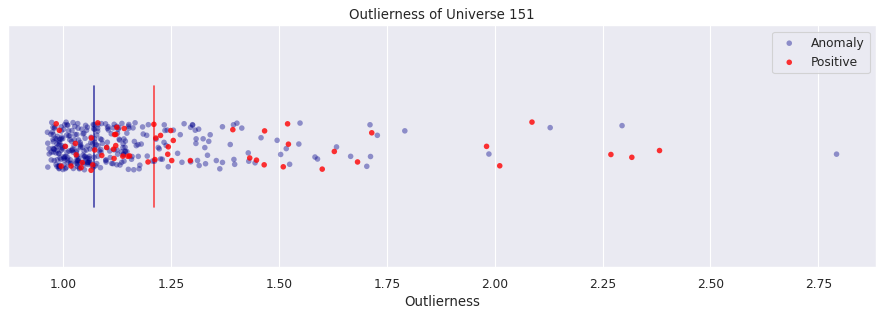

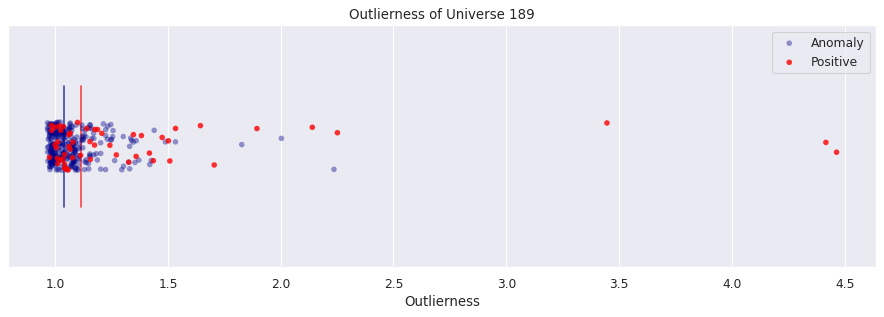

In [261]:
vis.outlierness_supervised(Y_collection, outlierness_pred)

**ROC**

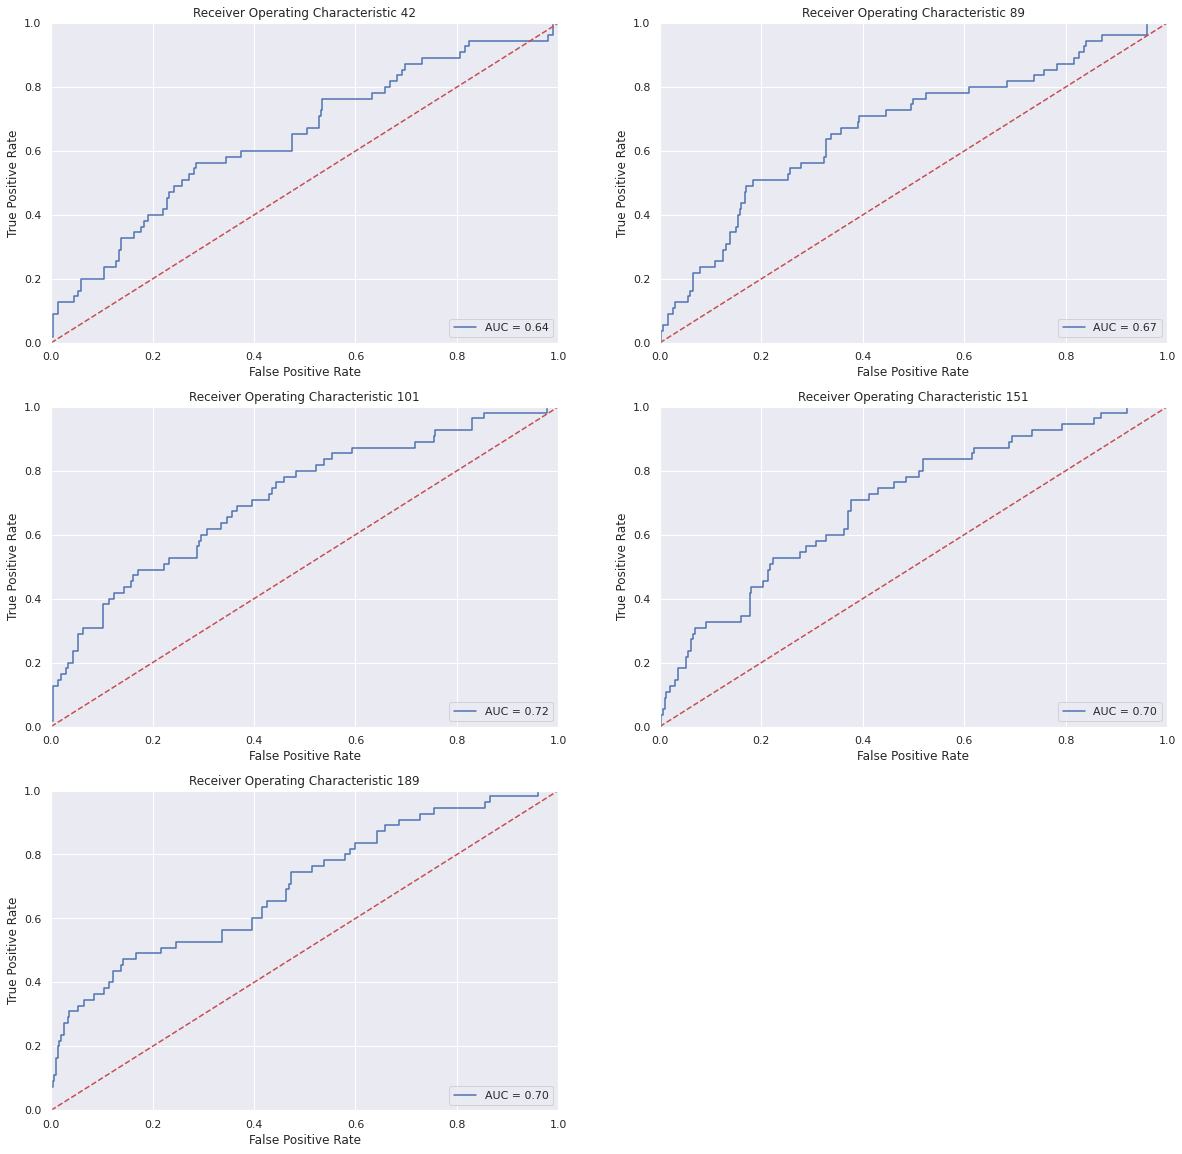

In [262]:
vis = ToolsVisualization()

vis.ROC_plot_total(Y_collection, outlierness_pred, 1)

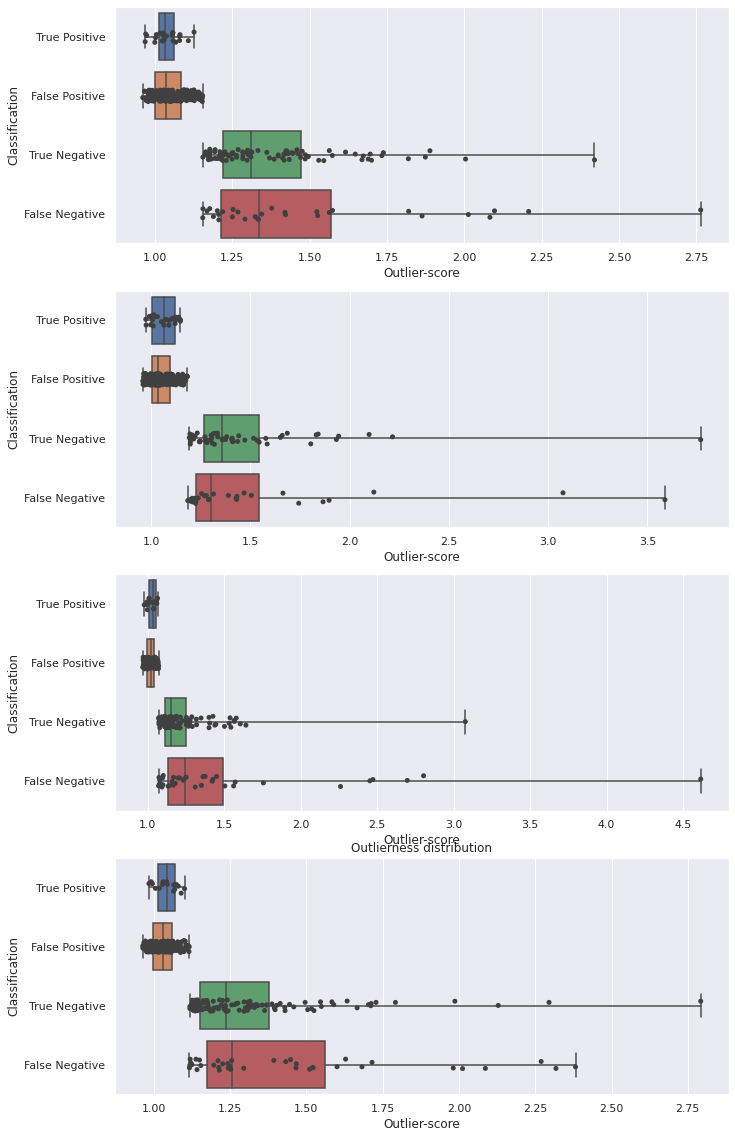

In [263]:
vis = ToolsVisualization()

vis.outlierness_plot_total(Y_collection, y_pred, outlierness_pred, normal=1, anomaly=-1)

**CONFUSION MATRIX**

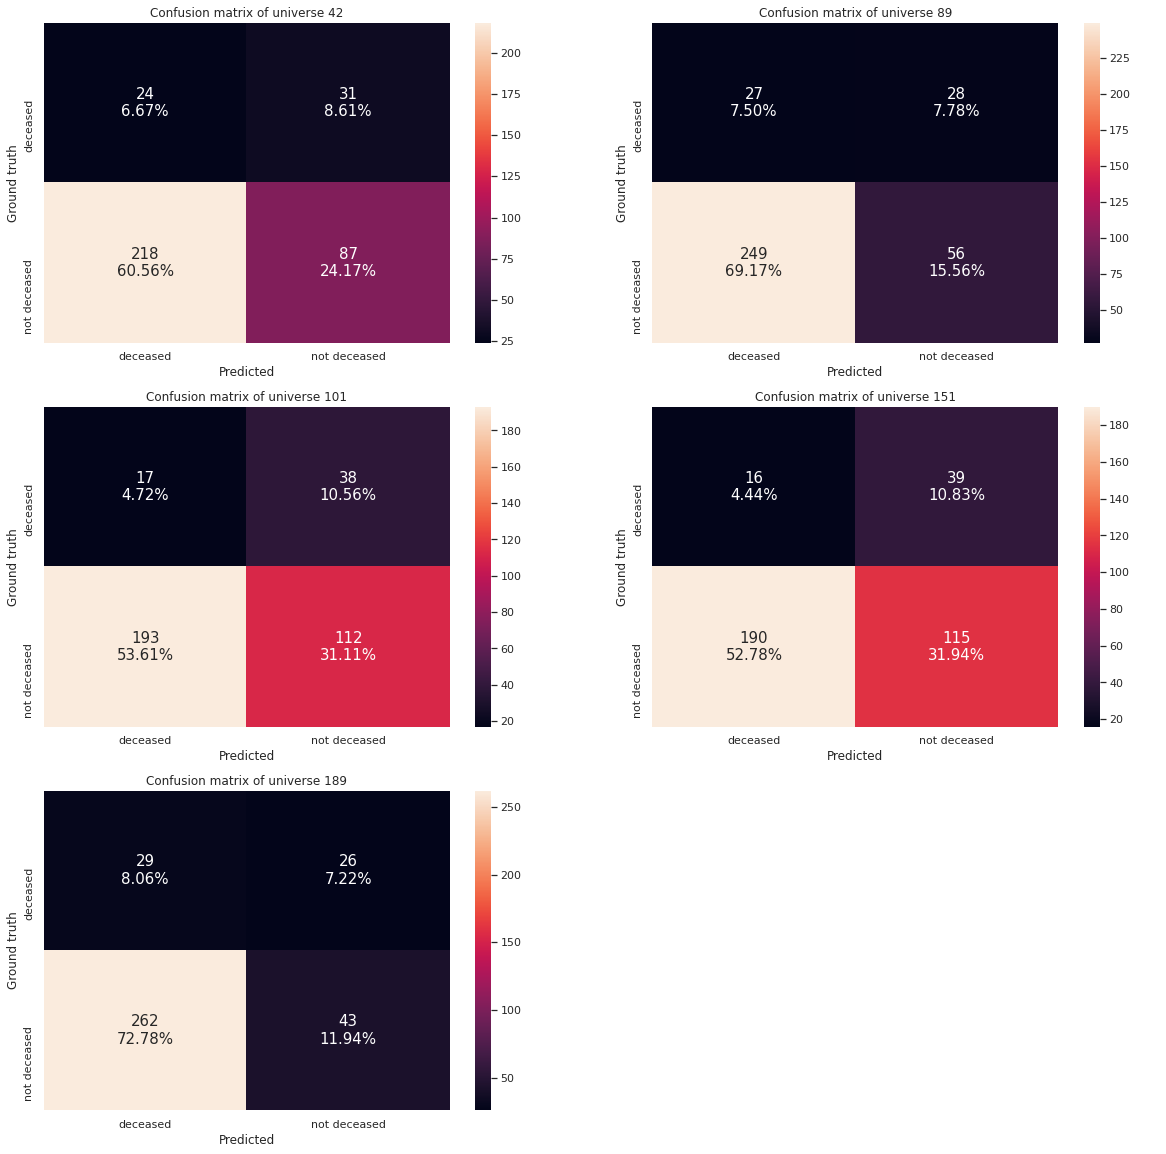

In [264]:
vis.confusion_matrix_plot_total(Y_collection, y_pred, [1, -1], normal='deceased',anomaly='not deceased')

**EVALUATION METRICS**

In [265]:
ev = tool.metric_evaluation(Y_collection, y_pred, outlierness_pred, 1)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Prediction      |   Pos Neg [42]  |   Pos Neg [89]  |  Pos Neg [101]  |  Pos Neg [151]  |  Pos Neg [189]  |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Positive        |       24 31     |       27 28     |       17 38     |       16 39     |       29 26     |
| Negative        |      218 87     |      249 56     |     193 112     |     190 115     |      262 43     |
| --------------- | --------------- | --------------- | --------------- | --------------- | --------------- |
| AUC             |      0.644      |      0.674      |      0.716*     |      0.703      |      0.700      |
| Accuracy        |      0.308      |      0.231      |      0.358      |      0.364*     |      0.200      |
| Precision       |      0.099      |      0.098      |      0.081      |      0.078      |      0.100*     |
| Sensitiv

In [266]:
for col in ev.columns:
    print(f'{col}\t Mean: {ev[col].mean()}\t Std: {ev[col].std()}')

AUC	 Mean: 0.6874038748137108	 Std: 0.02874718758837646
Accuracy	 Mean: 0.29222222222222227	 Std: 0.07428673177976346
Precision	 Mean: 0.09105565638576969	 Std: 0.01080469360380477
Sensitivity	 Mean: 0.41090909090909095	 Std: 0.10648400337706415
Specificity	 Mean: 0.27081967213114755	 Std: 0.10635794704561634
F1-score	 Mean: 0.14865909283089218	 Std: 0.02139363335802051


In [267]:
ev

,AUC,Accuracy,Precision,Sensitivity,Specificity,F1-score
42,0.643994,0.308333,0.099174,0.436364,0.285246,0.161616
89,0.673741,0.230556,0.097826,0.490909,0.183607,0.163142
101,0.716304,0.358333,0.080952,0.309091,0.367213,0.128302
151,0.702593,0.363889,0.077670,0.290909,0.377049,0.122605
189,0.700387,0.200000,0.099656,0.527273,0.140984,0.167630


# Local outlier identification

## OCSVM

**Train outlierness computing**

In [ ]:
low_gamma = 0.1
top_gamma = 0.05

low_nu = 0.05
top_nu = 0.1
ocsvm_params= {
#     'gamma' : np.linspace(low_gamma, top_gamma, 5+1)[1:],
#     'nu' : np.linspace(low_nu, top_nu, 20+1)[1:]
    'nu': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]
}

pl = Pipeline(OneClassSVM(), X_collection, Y_collection, feature_keep = ['CD0000AGE', 'CTHSDXXTEMP', 'CTHSDXXSAT', 'CTHSDXXRATE'], f_filter ='var_ratio', parameters = ocsvm_params)

############# FILTERING #############

pl._fil = 'var_ratio'
# ['med', 'med_mean', 'auc']
pl.feature_filtering(n_drop = 25)

############# ROW REMOVAL #############

train_out, train_remove = pl.row_removal(visual = 0)

**Sample identificationg along all universes**

In [240]:
# Samples with high outlierness in train set
total_core = []
for idx in train_remove: total_core = np.hstack((total_core, train_remove[idx]))

unique_core, counts = np.unique(total_core, return_counts=True)
count_dict = dict(zip(unique_core, counts))

count_dict = {k: v for k, v in sorted(count_dict.items(), key=lambda item: item[1], reverse=True)}


print('Rows with outlierness over quantile 0.9 of their subset, and the number of times they were marked.\n\n',str(count_dict))

Rows with outlierness over quantile 0.9 of their subset, and the number of times they were marked.

 {54.0: 5, 570.0: 5, 825.0: 5, 1944.0: 5, 2005.0: 5, 292.0: 4, 527.0: 4, 819.0: 4, 1045.0: 4, 1199.0: 4, 1517.0: 4, 1800.0: 4, 326.0: 3, 700.0: 3, 750.0: 3, 1254.0: 3, 1335.0: 3, 1583.0: 3, 1619.0: 3, 1827.0: 3, 2073.0: 3, 2499.0: 3, 38.0: 2, 417.0: 2, 590.0: 2, 660.0: 2, 890.0: 2, 1418.0: 2, 1488.0: 2, 2170.0: 2, 36.0: 1, 87.0: 1, 100.0: 1, 265.0: 1, 307.0: 1, 599.0: 1, 950.0: 1, 988.0: 1, 1024.0: 1, 1085.0: 1, 1300.0: 1, 1366.0: 1, 1375.0: 1, 1417.0: 1, 1470.0: 1, 1480.0: 1, 1716.0: 1, 1767.0: 1, 1769.0: 1, 1805.0: 1, 1857.0: 1, 1930.0: 1, 1972.0: 1, 1989.0: 1, 2091.0: 1, 2514.0: 1}


In [13]:
data_train_outlier = pd.DataFrame(columns=X_data.columns)
sample_idx = [326, 700, 750, 1254, 1335, 1583, 1619, 1827, 2073, 2499]
for idx in sample_idx:
    data_train_outlier.loc[idx] = X_data.loc[idx]

In [14]:
data_train_outlier.to_csv("train_outlier.csv", header=None, index=None)

**Mean of feature per class**

In [11]:
pos_index = Y_data.loc[Y_data['ED0DISWHY']==1].index
neg_index = Y_data.loc[Y_data['ED0DISWHY']==-1].index

X_positive = X_data.loc[pos_index,:]
X_negative = X_data.loc[neg_index,:]


feature_mean_pos = pd.Series([round(X_positive[column].mean(),4) for column in X_positive.columns], index=X_positive.columns)
feature_mean_neg = pd.Series([round(X_negative[column].mean(),4) for column in X_negative.columns], index=X_negative.columns)

In [47]:
feature_mean_pos.to_csv("mean_pos.csv", header=None, index=None)

In [12]:
feature_mean_neg.to_csv("mean_neg.csv", header=None, index=None)

# Post classification data analysis

In [135]:
# Imports
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean, cityblock
from sklearn.metrics import silhouette_samples, silhouette_score

# Configuration
%matplotlib notebook

**Standarizing all features. No features removed.**

In [81]:
# Data scaling
scaler = StandardScaler()


s_data =  scaler.fit_transform(X_data)

X_data_scaled = pd.DataFrame.from_records(s_data)
X_data_scaled.index = X_data.index
X_data_scaled = X_data_scaled.rename({i:X_data.columns[i] for i in range(0,44)}, axis='columns')

## Clustering

**k-mean clustering**

<IPython.core.display.Javascript object>


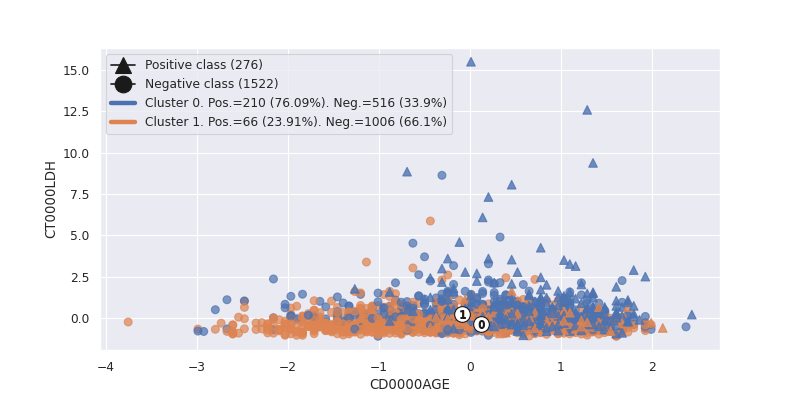

In [181]:
########### Clustering (2D visualization) ###########

# Figure
ax = plt.figure(figsize=(10, 5), dpi=80).gca()

# K-means
k = 2
kmeans = KMeans(n_clusters=k, random_state=0)
columns = ['CD0000AGE', 'CT0000LDH']#'CTHSDXXSAT'] # 'CTHSDXXTEMP'] 

# Configuration
colors = sns.color_palette("deep", n_colors=k)
total_pos = Y_data.loc[Y_data['ED0DISWHY']==1].shape[0]
total_neg = Y_data.loc[Y_data['ED0DISWHY']==-1].shape[0]

legend_elements = [Line2D([0], [0], marker='^', color='k', label=f'Positive class ({total_pos})',
                          markerfacecolor='k', markersize=15),
                   Line2D([0], [0], marker="o", color='k', label=f'Negative class ({total_neg})',
                          markerfacecolor='k', markersize=15)]

# Apply k-means
pred = pd.DataFrame()
pred['cluster'] = kmeans.fit_predict(X_data_scaled)
pred['c'] = pred.cluster.map({i:colors[i] for i in range(k)})
pred.index = X_data.index

# Process results, discriminate by class
pos_index = Y_data.loc[Y_data['ED0DISWHY']==1].index
neg_index = Y_data.loc[Y_data['ED0DISWHY']==-1].index

pos_data = X_data_scaled.loc[pos_index,:]
neg_data = X_data_scaled.loc[neg_index,:]

n_pos_total = np.shape(pos_data)[0]
n_neg_total = np.shape(neg_data)[0]

for i in range(k):
    idx_cluster = pred.loc[pred['cluster']==i].index
    idx_pos_cl = pos_index.intersection(idx_cluster)
    idx_neg_cl = neg_index.intersection(idx_cluster)
    
    n_pos = pos_data.loc[idx_pos_cl,:].shape[0]
    n_neg = neg_data.loc[idx_neg_cl,:].shape[0]
   
    legend_elements.append(Line2D([0], [0], color=colors[i], lw=4, label=f'Cluster {i}. Pos.={n_pos} ({round(n_pos/n_pos_total*100,2)}%). Neg.={n_neg} ({round(n_neg/n_neg_total*100,2)}%)'))


# Plot clustering
plt.scatter(neg_data[columns[0]], neg_data[columns[1]], c=pred.loc[neg_index,'c'], s=50, marker='o', label='Negative samples', alpha=0.7)
plt.scatter(pos_data[columns[0]], pos_data[columns[1]], c=pred.loc[pos_index,'c'], s=60, marker="^", label='Positive samples', alpha=0.8)#, edgecolors='k')

# Plot centered labes for each cluster
centers = kmeans.cluster_centers_
# Draw white circles at cluster centers
plt.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' % (i), alpha=1, s=50, edgecolor='k')
                
plt.legend(handles=legend_elements)

plt.ylabel(columns[1])
plt.xlabel(columns[0])
plt.show()

**Computing silhouette**

<IPython.core.display.Javascript object>


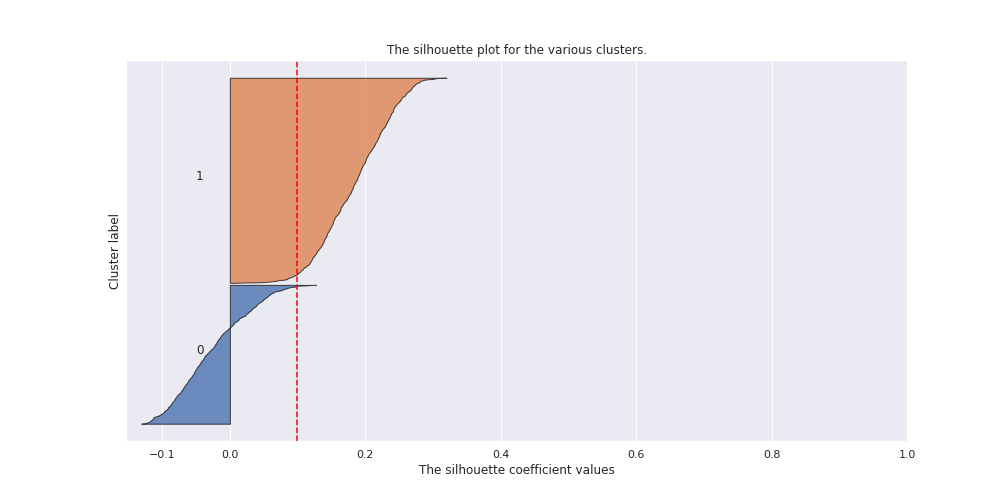

For n_clusters = 2 
The average silhouette_score is : 0.09939126915919626


In [182]:
import matplotlib.cm as cm

fig, ax1 = plt.subplots()
fig.set_size_inches(14, 7)

# Compute the silhouette score for clustering
silhouette_avg = silhouette_score(X_data_scaled, pred['cluster'])
print("For n_clusters =", k, "\nThe average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_data_scaled, pred['cluster'])

y_lower = 10
for i in range(k):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[pred['cluster'] == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=colors[i], edgecolor='k', alpha=0.8)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

## Distance between classes

**Euclidean distance**

In [133]:
data = X_data_scaled.copy()
data['ED0DISWHY'] = Y_data['ED0DISWHY']

pos_index = Y_data.loc[Y_data['ED0DISWHY']==1].index
neg_index = Y_data.loc[Y_data['ED0DISWHY']==-1].index

# pos_data = X_data.loc[pos_index,:]
# neg_data = X_data.loc[neg_index,:]

## Check https://math.stackexchange.com/questions/190123/distance-between-two-sets-of-points

distances = pd.DataFrame(index=data.index)

for idx in tqdm(data.index, total=len(data.index), desc='Euclidean distance'):
    pos_distances = []
    neg_distances = []
    sample = data.loc[idx]
    for pair_idx in data.index:
        pair = data.loc[pair_idx]
        if Y_data.loc[pair_idx,'ED0DISWHY']==1:
            pos_distances.append(euclidean(sample, pair))
        else:
            neg_distances.append(euclidean(sample, pair))
        
    distances.loc[idx, 'positive'] = np.mean(pos_distances)
    distances.loc[idx, 'negative'] = np.mean(neg_distances)


Euclidean distance:   0%|          | 0/1798 [00:00<?, ?it/s]

In [134]:
pos_neg_mean = distances.loc[pos_index,'negative'].mean()
neg_pos_mean = distances.loc[neg_index,'positive'].mean()
pos_pos_mean = distances.loc[pos_index,'positive'].mean()
neg_neg_mean = distances.loc[neg_index,'negative'].mean()
print(f'Euclidean distances (mean).\nPositive-Positive: {round(pos_pos_mean, 3)}\nPositive-Negative (Negative-Positive): {round(neg_pos_mean, 3)}\nNegative-Negative: {round(neg_neg_mean, 3)}')

Euclidean distances (mean).
Positive-Positive: 10.989
Positive-Negative (Negative-Positive): 10.163
Negative-Negative: 7.938


**Manhattan**

In [86]:
data = X_data.copy()
data['ED0DISWHY'] = Y_data['ED0DISWHY']

pos_index = Y_data.loc[Y_data['ED0DISWHY']==1].index
neg_index = Y_data.loc[Y_data['ED0DISWHY']==-1].index

# pos_data = X_data.loc[pos_index,:]
# neg_data = X_data.loc[neg_index,:]

## Check https://math.stackexchange.com/questions/190123/distance-between-two-sets-of-points

distances = pd.DataFrame(index=data.index)

for idx in tqdm(data.index, total=len(data.index), desc='Euclidean distance'):
    pos_distances = []
    neg_distances = []
    sample = data.loc[idx]
    for pair_idx in data.index:
        pair = data.loc[pair_idx]
        if Y_data.loc[pair_idx,'ED0DISWHY']==1:
            pos_distances.append(cityblock(sample, pair))
        else:
            neg_distances.append(cityblock(sample, pair))
        
    distances.loc[idx, 'positive'] = np.mean(pos_distances)
    distances.loc[idx, 'negative'] = np.mean(neg_distances)


Euclidean distance:   0%|          | 0/1798 [00:00<?, ?it/s]

In [95]:
pos_neg_mean = distances.loc[pos_index,'negative'].mean()
neg_pos_mean = distances.loc[neg_index,'positive'].mean()
pos_pos_mean = distances.loc[pos_index,'positive'].mean()
neg_neg_mean = distances.loc[neg_index,'negative'].mean()
print(f'Manhattan distances (mean):\n\
* Positive-Positive: {round(pos_pos_mean, 3)}\n\
* Positive-Negative (Negative-Positive): {round(neg_pos_mean, 3)}\n\
* Negative-Negative: {round(neg_neg_mean, 3)}')

Manhattan distances (mean):
* Positive-Positive: 6989.97
* Positive-Negative (Negative-Positive): 5377.972
* Negative-Negative: 3206.15


# Appendix

In [50]:
r = np.random.RandomState(1234)

In [308]:
def outlierness_unsupervised_ap(outlier_score, normal=1, anomaly=-1, cutoff = -1, title = 'Outlierness represent'): 
# Visualize outlier-score (UNSUPERVISED WAY)
    ax = plt.figure(figsize=(10, 5), dpi=80).gca()
    plt.title(f'{title}')
    col = sns.color_palette("deep", n_colors=2)
    if (cutoff != -1):  
#         q = outlier_score.quantile(quantile)
        low_q = outlier_score.loc[outlier_score<cutoff]
        high_q = outlier_score.loc[outlier_score>=cutoff]
        sns.stripplot(x=low_q, ax = ax, color=col[0], label = f'Sample with low outlierness')
        sns.stripplot(x=high_q, ax = ax, color=col[1], label = f'Sample with high outlierness')
        plt.axvline(x=cutoff, color='g', linestyle='-', label=f'Cut-off value: {cutoff}')
        plt.xlabel('Outlierness')
        plt.legend()
    else:
        sns.stripplot(x=outlier_score, ax = ax, color = col[0])

#         plt.xticks(np.arange(min(outlier_score[universe]), max(outlier_score[universe])+1, 1.0))
    

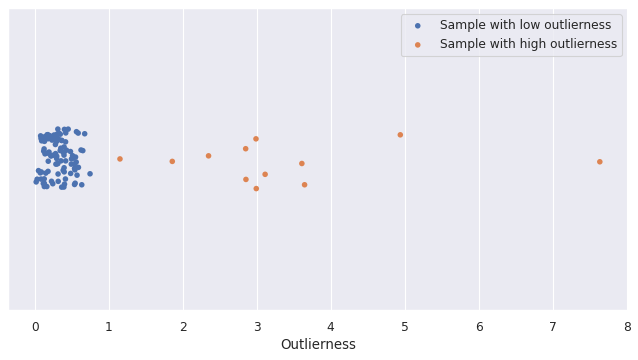

In [303]:
low = pd.Series(r.normal(loc=0.3, scale=0.2, size=(1,100))[0])
high = pd.Series(r.normal(loc=2, scale=2, size=(1,20))[0])
neg_idx = low.loc[low<0].index
low.drop(index = neg_idx, inplace=True)
neg_idx = high.loc[high<0].index
high.drop(index = neg_idx, inplace=True)

total = low.append(high)
outlierness_unsupervised_ap(total, cutoff = 1.1, title = "")


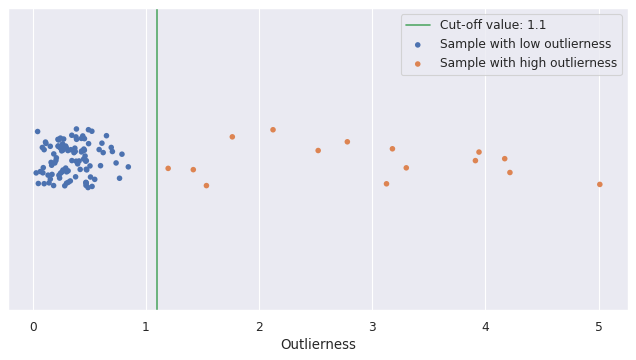

In [310]:
low = pd.Series(r.normal(loc=0.3, scale=0.2, size=(1,100))[0])
high = pd.Series(r.normal(loc=2, scale=2, size=(1,20))[0])
neg_idx = low.loc[low<0].index
low.drop(index = neg_idx, inplace=True)
neg_idx = high.loc[high<0].index
high.drop(index = neg_idx, inplace=True)

total = low.append(high)
outlierness_unsupervised_ap(total, cutoff = 1.1, title = "")


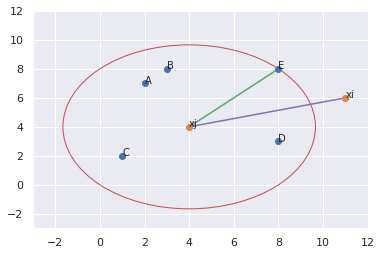

In [74]:
# LOF representation
from scipy.spatial.distance import euclidean

fig, ax = plt.subplots()

ax.set_xlim([-3,12])
ax.set_ylim([-3,12])
colors = sns.color_palette("deep", n_colors=5)

points = np.array([[2,7],[3,8],[1,2],[8,3],[8,8]])
labels = ['A', 'B', 'C', 'D', 'E']
for i,point in zip(range(len(points)), points):
    plt.text(point[0], point[1], labels[i])
ax.scatter(points[:, 0], points[:, 1], color=colors[0],zorder=2)

    
target = [4,4]
max_point = [points[4,0], points[4,1]]
plt.text(target[0], target[1], 'xj')
ax.plot([target[0], points[4,0]],[target[1], points[4,1]], color = colors[2],zorder=1)
ax.scatter(target[0], target[1], color=colors[1],zorder=2)

ext = [11,6]
plt.text(ext[0], ext[1], 'xi')
ax.scatter(ext[0], ext[1], color = colors[1], zorder=2)
ax.plot([target[0], ext[0]],[target[1], ext[1]], color = colors[4],zorder=1)


cir = plt.Circle(target, euclidean(target, max_point), fill=False, color = colors[3])
ax.add_patch(cir)

# legend_elements = [cir]
# plt.legend(legend_elements)